## Development notebook for `build_predictions()` and `build_heatmap()`


In [ ]:
# np_format = {}
# np_format['float'] =  lambda x: "%10.4f" % x
# np_format['int']   =  lambda x: "%10d" % x
# np.set_printoptions(linewidth=195, precision=4, floatmode='fixed', threshold =10000, formatter = np_format)

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, math, io, time, gc, argparse, platform, pprint, pickle, copy
import numpy as np
import tensorflow as tf
import keras
import keras.backend as KB
sys.path.append('../')

print('Current working dir: ', os.getcwd())
if '../..' not in sys.path:
    print("appending '..' to sys.path")
    sys.path.append('../..')

syst = platform.system()
if syst == 'Windows':
    dataset_path = "E:/git_projs/MRCNN3/train_newshapes/"
elif syst == 'Linux':
    dataset_path = "/home/kbardool/mrcnn3/train_newshapes/"
else :
    raise Error('unrecognized system ') 
import mrcnn.visualize     as visualize
import mrcnn.visualize_2     as vis2
import mrcnn.utils         as utils
import mrcnn.prep_notebook as prep
from datetime            import datetime   
from mrcnn.utils         import command_line_parser, Paths, logt
from mrcnn.config        import Config
from mrcnn.dataset       import Dataset 
from mrcnn.prep_notebook import build_mrcnn_training_pipeline_newshapes, build_fcn_training_pipeline_newshapes
# from mrcnn.prep_notebook import build_mrcnn_training_pipeline_newshapes
from mrcnn.newshapes     import prep_newshape_dataset
from mrcnn.datagen       import data_gen_simulate

pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current working dir:  /home/kbardool/git_projs/mrcnn3/notebooks


In [3]:
##------------------------------------------------------------------------------------
## Parse command line arguments
##------------------------------------------------------------------------------------
parser = command_line_parser()
input_parms = " --epochs          2 "
input_parms +=" --steps_in_epoch 10 " 
input_parms +=" --val_steps       2 " 
input_parms +=" --last_epoch      0 "
input_parms +=" --batch_size      2 "
input_parms +=" --lr        0.00001 "
input_parms +=" --mrcnn_logs_dir train_mrcnn_newshapes"
input_parms +=" --fcn_logs_dir   train_fcn8L2_newshapes " 
input_parms +=" --fcn_bce_loss_method    1  " 
# input_parms +=" --fcn_bce_loss_class     3  "
input_parms +=" --scale_factor     1 " 
input_parms +=" --mrcnn_model    last "
input_parms +=" --fcn_model      init "
input_parms +=" --fcn_arch       fcn8l2 " 
input_parms +=" --fcn_layers     all " 
input_parms +=" --sysout        screen "
input_parms +=" --new_log_folder   "        

parser = utils.command_line_parser()
args = parser.parse_args(input_parms.split())
utils.display_input_parms(args)


   Arguments passed :
   --------------------
   batch_size                     2
   coco_classes                   None
   epochs                         2
   evaluate_method                1
   fcn_arch                       FCN8L2
   fcn_bce_loss_class             0
   fcn_bce_loss_method            1
   fcn_layers                     ['all']
   fcn_logs_dir                   train_fcn8L2_newshapes
   fcn_losses                     fcn_BCE_loss
   fcn_model                      init
   last_epoch                     0
   lr                             0.00001
   mrcnn_exclude_layers           None
   mrcnn_layers                   ['mrcnn', 'fpn', 'rpn']
   mrcnn_logs_dir                 train_mrcnn_newshapes
   mrcnn_model                    last
   new_log_folder                 True
   opt                            ADAGRAD
   scale_factor                   1
   steps_in_epoch                 10
   sysout                         SCREEN
   val_steps                      2




#### Build Mrcnn model

In [4]:
mrcnn_model = build_mrcnn_training_pipeline_newshapes(args, verbose = 1)

>>> Initialize Paths
 Linx  Linux

   Arguments passed :
   --------------------
   batch_size                     2
   coco_classes                   None
   epochs                         2
   evaluate_method                1
   fcn_arch                       FCN8L2
   fcn_bce_loss_class             0
   fcn_bce_loss_method            1
   fcn_layers                     ['all']
   fcn_logs_dir                   train_fcn8L2_newshapes
   fcn_losses                     fcn_BCE_loss
   fcn_model                      init
   last_epoch                     0
   lr                             0.00001
   mrcnn_exclude_layers           None
   mrcnn_layers                   ['mrcnn', 'fpn', 'rpn']
   mrcnn_logs_dir                 train_mrcnn_newshapes
   mrcnn_model                    last
   new_log_folder                 True
   opt                            ADAGRAD
   scale_factor                   1
   steps_in_epoch                 10
   sysout                         SCREEN
   val_st

    mrcnn_class_logits             :  shape: (?, 32, 7)            KB.shape:(None, 32, 7)         Keras Tensor: True
    mrcnn_class_logits (final)     :  shape: (?, 32, 7)            KB.shape:(None, 32, 7)         Keras Tensor: True
    mrcnn_probs                    :  shape: (?, 32, 7)            KB.shape:(None, 32, 7)         Keras Tensor: True
    mrcnn_probs (final)            :  shape: (?, 32, 7)            KB.shape:(None, 32, 7)         Keras Tensor: True
    mrcnn_bbox_fc                  :  shape: (?, 32, 28)           KB.shape:(None, 32, 28)        Keras Tensor: True
    mrcnn_bbox_fc reshaped output  :  shape: (?, 32, 7, 4)         KB.shape:(None, 32, 7, 4)      Keras Tensor: True
    mrcnn_bbox (final)             :  shape: (?, 32, 7, 4)         KB.shape:(None, 32, 7, 4)      Keras Tensor: True
--------------------------------
>>>  CHM Layer  
--------------------------------
    > CHMLayer Call()              :  list length: 4
    mrcnn_class                    :  shape: 

    prob_grid_clipped              :  shape: (?, 128, 128)         KB.shape:(None, 128, 128)      Keras Tensor: False
    old_style_scores               :  shape: (2, 7, 32, 3)         KB.shape:(2, 7, 32, 3)         Keras Tensor: False
    alt_scores_1                   :  shape: (?, 3)                KB.shape:(None, 3)             Keras Tensor: False
    alt_scores_1(by class)         :  shape: (2, 7, 32, 3)         KB.shape:(2, 7, 32, 3)         Keras Tensor: False
    alt_scores_1_norm(by_class)    :  shape: (2, 7, 32, 3)         KB.shape:(2, 7, 32, 3)         Keras Tensor: False
    Scatter out the probability distributions based on class --------------
    pt2_ind                        :  shape: (?, 3)                KB.shape:(None, 3)             Keras Tensor: False
    prob_grid                      :  shape: (?, 128, 128)         KB.shape:(None, 128, 128)      Keras Tensor: False
    gauss_heatmap                  :  shape: (2, 7, 32, 128, 128)  KB.shape:(2, 7, 32, 128, 128)  

    Weights file loaded: /home/kbardool/models_newshapes/train_mrcnn_newshapes/mrcnn20181216T0000/mrcnn_0472.h5 
MRCNN  MODEL Load weight file COMPLETE 


##  Load dataset

In [5]:
from mrcnn.datagen import data_generator

##------------------------------------------------------------------------------------
## Build & Load Training and Validation datasets
##------------------------------------------------------------------------------------
# dataset_train, train_generator = prep_newshape_dataset( mrcnn_model.config, 10000, generator=True)
# dataset_val  , val_generator   = prep_newshape_dataset( mrcnn_model.config,  2500, generator=True)
# with open('E:\\git_projs\\MRCNN3\\train_newshapes\\newshapes_training_dataset_10000_A.pkl', 'wb') as outfile:
#     pickle.dump(dataset_train, outfile)
# with open('E:\\git_projs\\MRCNN3\\train_newshapes\\newshapes_validation_dataset_2500_A.pkl', 'wb') as outfile:
#     pickle.dump(dataset_val, outfile)

## -- OR --

with open(os.path.join(dataset_path, 'newshapes_training_dataset_10000_A.pkl'), 'rb') as outfile:
    dataset_train = pickle.load(outfile)
with open(os.path.join(dataset_path, 'newshapes_validation_dataset_2500_A.pkl'), 'rb') as outfile:
    dataset_val = pickle.load(outfile)
class_names = dataset_train.class_names
# dataset_train.display_active_classes()
# print(mrcnn_model.config.BATCH_SIZE, fcn_model.config.BATCH_SIZE)
print(len(dataset_train.image_ids), len(dataset_val.image_ids))

10000 2500


In [6]:
## If we desire a generator, here it is:    
train_generator = data_generator(dataset_train, mrcnn_model.config, batch_size=mrcnn_model.config.BATCH_SIZE,
                                   shuffle = False, augment = False) 
val_generator = data_generator(dataset_val, mrcnn_model.config, batch_size=mrcnn_model.config.BATCH_SIZE,
                                   shuffle = False, augment = False) 

In [7]:
print(dataset_train.active_class_ids)
# pp.pprint(dataset_train.category_to_class_map)
print()
pp.pprint(dataset_train.category_to_external_class_map)
print(' dataset_train.source_objs:   ',dataset_train.source_objs)
print(' len of dataset_train.image_info: ', len(dataset_train.image_info))
print(dataset_train.image_info[0].keys())
for i in range(10):
    p = dataset_train.image_info[4598]
    print(i,p['id'], p['source'], p['path'])###  Display some images from training and val datasets

[1, 2, 3, 4, 5, 6]

{None: [1, 2, 3, 4, 5, 6], 'background': [0]}
 dataset_train.source_objs:    {}
 len of dataset_train.image_info:  10000
dict_keys(['id', 'bg_color', 'width', 'shapes', 'path', 'source', 'height'])
0 4598 shapes None
1 4598 shapes None
2 4598 shapes None
3 4598 shapes None
4 4598 shapes None
5 4598 shapes None
6 4598 shapes None
7 4598 shapes None
8 4598 shapes None
9 4598 shapes None


###  Display some images from training and val datasets

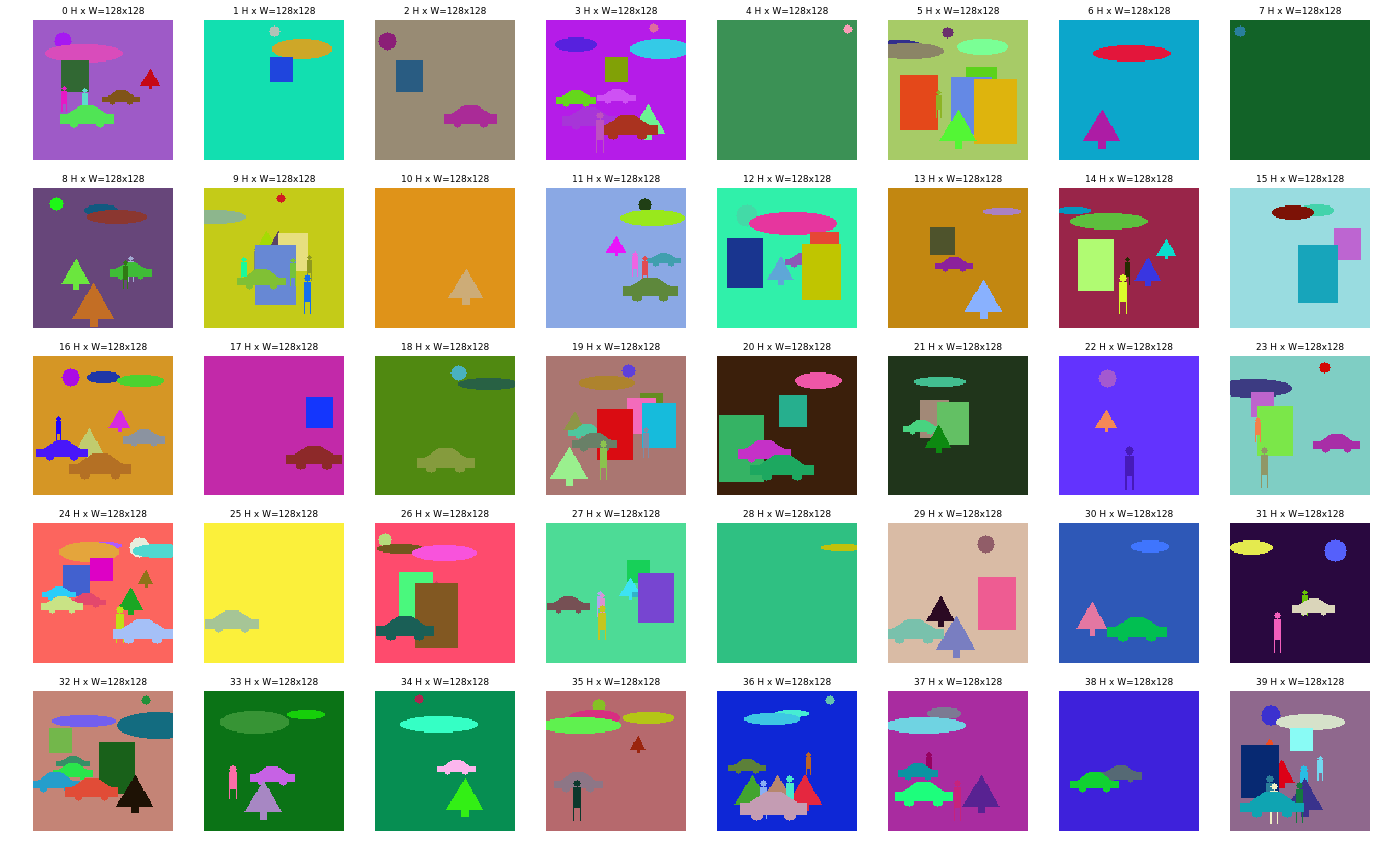

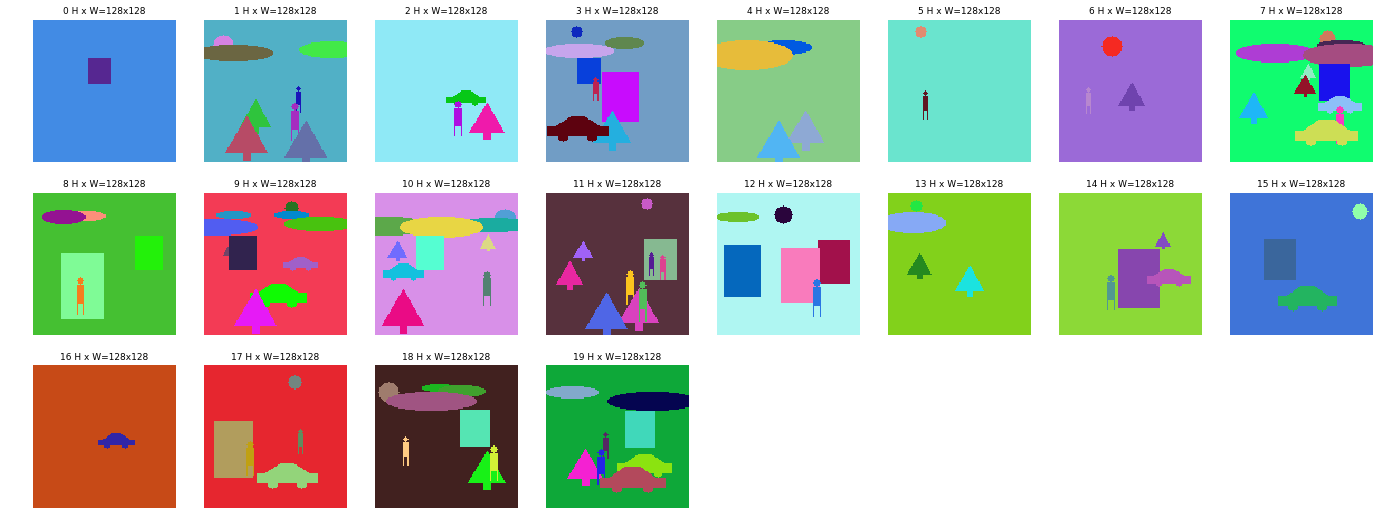

In [8]:
image_list = list(range(0,40))
image_titles = [str(i) for i in image_list]
images = prep.get_image_batch(dataset_train, image_list)
visualize.display_images(images, titles = image_titles, cols = 8, width = 24)

image_list = list(range(0,20))
image_titles = [str(i) for i in image_list]
images = prep.get_image_batch(dataset_val, image_list)
visualize.display_images(images, titles = image_titles, cols = 8, width = 24)

### Display Images

####  Display image with Ground Truth bounding boxes and masks

In [ ]:
train_batch_x = prep.get_training_batch(dataset_train, mrcnn_model.config, [0,1])
# train_batch_x, _ = next(train_generator) 
# train_batch_x = data_gen_simulate(dataset_train, mrcnn_model.config, [0,1])
# visualize.display_training_batch(dataset_train, train_batch_x)


In [ ]:
# IMAGE_LIST = train_batch_x[1][:,0]
# print('IMAGE_LIST : ', IMAGE_LIST)
# for image_id in IMAGE_LIST:
#     print()
#     print('IMAGE_ID : ', image_id)#### Load a specific image using image_id
#     annotations = dataset_train.image_info[image_id]["annotations"]
# #     print(annotations)
#     for annotation in annotations:
#         class_id = dataset_train.map_source_class_id( "coco.{}".format(annotation['category_id']))
#         print("coco.id: {} --> class_id : {}  - {} ".format(annotation['category_id'],class_id, dataset_train.class_names[class_id]))

####  Display Training / Validation Training set information

In [ ]:
print("Train Dataset Image Count: {}".format(len(dataset_train.image_ids)))
print("Training Dataset Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    
    
print("Validation Dataset Image Count: {}".format(len(dataset_val.image_ids)))
print("Validation Dataset Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
    print("{:3}. {:50}".format(i, info['name']))    

#### Display top masks for a random group of images

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 7)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

#### Display a random image with instances and mask

In [ ]:
# Load random image and mask.
# image_id = np.random.choice(dataset_train.image_ids)


image    = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_train.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
print(class_ids.shape[0], bbox.shape[0])
# Display image and instances
visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names)

## Run data through model

image id :  2
 Image_id    :  2  Reference:  [('sun', (139, 30, 119), (11, 19, 8, 8)), ('building', (41, 92, 130), (31, 51, 12, 14)), ('car', (170, 43, 151), (87, 90, 24, 12))] Coco Id: 2
 Image meta  :  [  2 128 128   3   0   0 128 128]
 Class ids   :  (3,)    [3 4 2]
 Class Names :  ['sun', 'building', 'car']
image id :  3
 Image_id    :  3  Reference:  [('sun', (222, 106, 160), (98, 7, 4, 4)), ('cloud', (87, 33, 222), (27, 22, 19, 6)), ('cloud', (52, 202, 231), (104, 26, 27, 9)), ('building', (129, 161, 6), (64, 45, 10, 11)), ('car', (206, 81, 244), (64, 71, 17, 8)), ('car', (101, 215, 28), (27, 73, 18, 9)), ('tree', (109, 242, 147), (93, 90, 19, 19)), ('car', (167, 53, 216), (39, 92, 24, 12)), ('car', (170, 51, 31), (74, 100, 27, 13)), ('person', (189, 81, 192), (49, 106, 3, 19))] Coco Id: 3
 Image meta  :  [  3 128 128   3   0   0 128 128]
 Class ids   :  (10,)    [3 6 6 4 2 2 5 2 2 1]
 Class Names :  ['sun', 'cloud', 'cloud', 'building', 'car', 'car', 'tree', 'car', 'car', 'perso

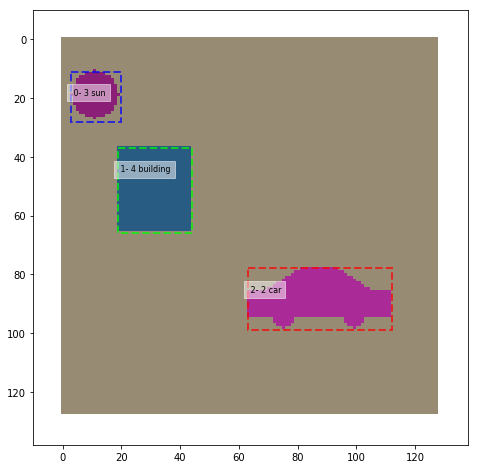

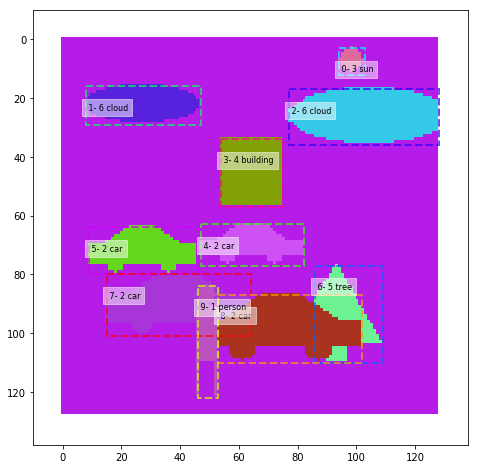

In [9]:
train_batch_x = prep.get_training_batch(dataset_train, mrcnn_model.config, [2,3])
# train_batch_x, _ = next(train_generator) 
# train_batch_x = data_gen_simulate(dataset_train, mrcnn_model.config, [0,1])
# visualize.display_training_batch(dataset_train, train_batch_x)


###  `run_mrcnn_training_pipeline()`

In [10]:
# outputs = run_mrcnn_training_pipeline(mrcnn_model, dataset_train, train_batch_x, verbose= 1)
model_output = mrcnn_model.get_layer_outputs(train_batch_x,  verbose = 1)

/* Inputs */
Input  0:  (input_image:0                           ) 	  Input shape: (2, 128, 128, 3)
Input  1:  (input_image_meta:0                      ) 	  Input shape: (2, 15)
Input  2:  (input_rpn_match:0                       ) 	  Input shape: (2, 4092, 1)
Input  3:  (input_rpn_bbox:0                        ) 	  Input shape: (2, 256, 4)
Input  4:  (input_gt_class_ids:0                    ) 	  Input shape: (2, 100)
Input  5:  (input_gt_boxes:0                        ) 	  Input shape: (2, 100, 4)

Requested layers:
-----------------
Layer   0:  (cntxt_layer/pred_heatmap:0              ) 	  Output shape: (2, 128, 128, 7)
Layer   1:  (cntxt_layer/pred_heatmap_scores:0       ) 	  Output shape: (2, 7, 32, 24)
Layer   2:  (cntxt_layer_gt/gt_heatmap:0             ) 	  Output shape: (2, 128, 128, 7)
Layer   3:  (cntxt_layer_gt/gt_heatmap_scores:0      ) 	  Output shape: (2, 7, 32, 24)
Layer   4:  (mrcnn_class_lambda/mrcnn_class:0        ) 	  Output shape: (?, 32, 7)
Layer   5:  (mrcnn_bbox_

#### Load output data

In [11]:
print(len(model_output))
model_pred_heatmap              = model_output[0]          # layer:  0   shape: (2, 128, 128, 7)
model_pred_heatmap_scores       = model_output[1]          # layer:  1   shape: (2, 7, 32, 23)
model_gt_heatmap                = model_output[2]          # layer:  2   shape: (2, 128, 128, 7)
model_gt_heatmap_scores         = model_output[3]          # layer:  3   shape: (2, 7, 32, 23)
model_mrcnn_class               = model_output[4]          # layer:  4   shape: (2, 32, 7)
model_mrcnn_bbox                = model_output[5]          # layer:  5   shape: (2, 32, 7, 4)
model_output_rois               = model_output[6]          # layer:  6   shape: (2, 32, 4)
model_target_class_ids          = model_output[7]          # layer:  7   shape: (2, 32)
model_target_bbox_deltas        = model_output[8]          # layer:  8   shape: (2, 32, 4)
model_roi_gt_boxes              = model_output[9]          # layer:  9   shape: (2, 32, 4)
model_mrcnn_class_logits        = model_output[10]          # layer: 10   shape: (2, 32, 7)
model_strided_slice_3           = model_output[11]          # layer: 11   shape: (2, 7)
model_rpn_roi_proposals         = model_output[12]          # layer: 12   shape: (2, 2000, 4)
model_pr_tensor                 = model_output[13]
model_gt_tensor                 = model_output[14]          # layer: 14   shape: (2, 7, 32, 8)
model_rpn_class_loss            = model_output[15]          # layer: 15   shape: (1, 1)
model_rpn_bbox_loss             = model_output[16]          # layer: 16   shape: (1, 1)
model_mrcnn_class_loss          = model_output[17]          # layer: 17   shape: (1, 1)
model_mrcnn_bbox_loss           = model_output[18]          # layer: 18   shape: (1, 1)

# model_mrcnn_class               = outputs[0]
# model_mrcnn_bbox                = outputs[1]
# model_output_rois               = outputs[2]
# model_target_class_ids          = outputs[3]
# model_roi_gt_boxes              = outputs[4]
# model_mrcnn_class_logits        = outputs[5]
for i in model_output:
    print(i.shape)

19
(2, 128, 128, 7)
(2, 7, 32, 24)
(2, 128, 128, 7)
(2, 7, 32, 24)
(2, 32, 7)
(2, 32, 7, 4)
(2, 32, 4)
(2, 32)
(2, 32, 4)
(2, 32, 4)
(2, 32, 7)
(2, 7)
(2, 2000, 4)
(2, 7, 32, 9)
(2, 7, 32, 9)
(1, 1)
(1, 1)
(1, 1)
(1, 1)


In [12]:
input_image          =  train_batch_x[0]
input_image_meta     =  train_batch_x[1]
input_gt_class_ids   =  train_batch_x[4]
input_gt_bboxes      =  train_batch_x[5]
print(' Input image shape is    :', input_image.shape)
print(' Input image_meta        :', type(input_image_meta), input_image_meta.shape)
print(' input_image_meta        :', input_image_meta[0,:10])
print(' input_gt_class_ids      :', input_gt_class_ids.shape)
print(' input_gt_bboxes         :', input_gt_bboxes.shape)
h, w = input_image.shape[1], input_image.shape[2]      #  tf.shape(input_image)[1], tf.shape(input_image)[2]
print('h/w:', h,w)
# input_gt_bboxes_norm = tf.identity(input_gt_bboxes / [h,w,h,w])
# print(' input_gt_bboxes_norm    :', input_gt_bboxes_norm.shape)

 Input image shape is    : (2, 128, 128, 3)
 Input image_meta        : <class 'numpy.ndarray'> (2, 15)
 input_image_meta        : [  2 128 128   3   0   0 128 128   1   1]
 input_gt_class_ids      : (2, 100)
 input_gt_bboxes         : (2, 100, 4)
h/w: 128 128


###  Run using `model.predict()`

In [ ]:
# from mrcnn.prep_notebook import display_training_batch
# train_batch_x, _ =  data_gen_simulate(dataset_train, mrcnn_model.config, [12,13])

for i in range(40):
    train_batch_x, train_batch_y = next(train_generator)

    results = mrcnn_model.keras_model.predict(train_batch_x)

    for i in range(results[1].shape[0]):
        if np.any(np.isnan(results[1][i])):
            print('\n Bad train_batch_x encountered (training phase) - epoch {} , image ids: {} -- Retry with next sample'.
                  format(0, train_batch_x[1][i,0]))    
        else:
            print('\n epoch {} , image ids: {} -- Is ok'.format(0, train_batch_x[1][i,0]))    
        

In [ ]:
print(type(results))
for i in results:
#     print( i.shape)
    print(i.shape, type(i), np.any(np.isnan(i)))
print(len(results))
# del mrcnn_detection, rpn_roi_proposals, mrcnn_class, mrcnn_bbox
pred_heatmap              = results[0]          # layer:  0   shape: (1, 128, 128, 7)
pred_heatmap_scores       = results[1]          # layer:  1   shape: (1, 7, 32, 23)
gt_heatmap                = results[2]          # layer:  2   shape: (1, 128, 128, 7)
gt_heatmap_scores         = results[3]          # layer:  3   shape: (1, 7, 32, 23)
mrcnn_class               = results[4]          # layer:  2   shape: (1, 1000, 81)
mrcnn_bbox                = results[5]          # layer:  3   shape: (1, 1000, 81, 4)
output_rois               = results[6]          # layer:  4    
target_class_ids          = results[7]          # layer:  4    
target_bbox_deltas        = results[8]          # layer:  4   
roi_gt_boxes              = results[9]          # layer:  0   shape: (1, 100, 6)
mrcnn_logits              = results[10]
active_class_ids          = results[11]
rpn_roi_proposals         = results[12]          # layer:  1   shape: (1, 1000, 4)
# mrcnn_class        = results['mrcnn_output'][2]          # layer:  2   shape: (1, 1000, 81)

# model_pr_hm              = results['mrcnn_output'][4]          # layer:  4   shape: (1, 256, 256, 81)
# model_pr_hm_scores       = results['mrcnn_output'][5]          # layer:  5   shape: (1, 81, 100, 11)
# print(type(model_output[4]))
# print(type(output_rois))
print([i.name for i in mrcnn_model.keras_model.outputs])
for i in results:
    print( i.shape)
        

#### Run `model.predict()`  in a loop to catch problems

In [ ]:
for epoch_idx in range(20):
    train_batch_x, train_batch_y = next(train_generator)
    print(train_batch_x[1][:,0])
    results = mrcnn_model.keras_model.predict(train_batch_x)
    
    if np.any(np.isnan(results[1])):
        print('\n Bad train_batch_x encountered (training phase) - epoch {} , image ids: {} -- Retry with next sample'.
              format(epoch_idx, train_batch_x[1][:,0]))
        break

In [ ]:
results = prep.run_mrcnn_training_pipeline(mrcnn_model, dataset_train, train_batch_x, verbose = True)

In [ ]:
for i in range(results['mrcnn_output'][1].shape[0]):
    if np.any(np.isnan(results['mrcnn_output'][1][i])):
        print('\n Bad train_batch_x encountered (training phase) - epoch {} , image ids: {} -- Retry with next sample'.
              format(0, train_batch_x[1][i,0]))    
    else:
        print('\n epoch {} , image ids: {} -- Is ok'.format(0, train_batch_x[1][i,0]))    
        

#### Load output from pipeline into variables

In [ ]:
print(len(results['mrcnn_output']))
# del mrcnn_detection, rpn_roi_proposals, mrcnn_class, mrcnn_bbox
# print(len(outputs), outputs.keys())
model_pr_heatmap                = results['mrcnn_output'][0]          # layer:  0   shape: (1, 256, 256, 81)
model_pr_heatmap_scores         = results['mrcnn_output'][1]          # layer:  1   shape: (1, 81, 200, 11)
model_gt_heatmap                = results['mrcnn_output'][2]          # layer:  2   shape: (1, 256, 256, 81)
model_gt_heatmap_scores         = results['mrcnn_output'][3]          # layer:  3   shape: (1, 81, 200, 11)
model_mrcnn_class               = results['mrcnn_output'][4]
model_mrcnn_bbox                = results['mrcnn_output'][5]
model_output_rois               = results['mrcnn_output'][6]
model_target_class_ids          = results['mrcnn_output'][7]
model_target_bbox_deltas        = results['mrcnn_output'][8]
model_roi_gt_boxes              = results['mrcnn_output'][9]
model_mrcnn_class_logits        = results['mrcnn_output'][10]
model_active_class_ids          = results['mrcnn_output'][11]          # layer:  6   shape: (1, 81)
model_rpn_roi_proposals         = results['mrcnn_output'][12]          # layer:  6   shape: (1, 81)
# print(type(output_rois))
for i in results['mrcnn_output']:
    print( i.shape)

#### Display output shapes

# print(outputs['image_batch'].shape)
for i in results:
    print('Group:', i.shape, np.any(np.isnan(i)))
#     for item in outputs[i]:
#         print(' Type ', type(item), item.shape)

#### Load input data

In [ ]:
input_image          =  train_batch_x[0]
input_image_meta     =  train_batch_x[1]
input_gt_class_ids   =  train_batch_x[4]
input_gt_bboxes      =  train_batch_x[5]
print(' Input image shape is    :', input_image.shape)
print(' Input image_meta        :', type(input_image_meta), input_image_meta.shape)
print(' input_image_meta        :', input_image_meta[0,:10])
print(' input_gt_class_ids      :', input_gt_class_ids.shape)
print(' input_gt_bboxes         :', input_gt_bboxes.shape)
h, w = input_image.shape[1], input_image.shape[2]      #  tf.shape(input_image)[1], tf.shape(input_image)[2]
print('h/w:', h,w)
# input_gt_bboxes_norm = tf.identity(input_gt_bboxes / [h,w,h,w])
# print(' input_gt_bboxes_norm    :', input_gt_bboxes_norm.shape)

## Display output from model

In [ ]:
float_formatter = lambda x: "%10.4f" % x
np_format = {}
np_format['float']=float_formatter
np.set_printoptions(linewidth=195, precision=3, floatmode='fixed', threshold =10000, formatter = np_format)

####  `input_gt_class_ids`, `input_gt_bboxes`

In [ ]:
print(mrcnn_model.config.NUM_CLASSES)
# print(roi_gt_boxes[0,:50] * [1024,1024,1024,1024])
print(input_gt_class_ids[0])
print(input_gt_class_ids[1])
cls_count = np.bincount(input_gt_class_ids[0],minlength=mrcnn_model.config.NUM_CLASSES)
print('cls_count: ', cls_count)
print(input_gt_bboxes[0])
# for i in range(input_gt_class_ids.shape[1]):
#     if input_gt_class_ids[0,i] == 1:
#         print(input_gt_class_ids[0,i], '   ', input_gt_bboxes[0,i])

####  Display `output_rois`

In [ ]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
img = 0
print(' output_rois')
print(model_output_rois.shape)
# print(output_rois[0,:40,:])
print(model_output_rois [0,:,:]* [h, w, h, w])

In [ ]:
# visualize.display_pr_hm_scores_box_info(model_pr_heatmap_scores[0], class_names, only = None)
vis2.display_pr_hm_scores(model_pred_heatmap_scores[0], class_names)

####  `mrcnn_class` , `argmax_mrcnn_class'

In [21]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
print(' mrcnn_class', model_mrcnn_class.shape)
print( model_mrcnn_class[0])
# 
max_mrcnn_class    = np.max(model_mrcnn_class, axis = 2)
argmax_mrcnn_class = np.argmax(model_mrcnn_class, axis = 2)

# print()
print('\n mrcnn_class Max Values   : ', max_mrcnn_class.shape)
print(max_mrcnn_class)

# print()
print(' mrcnn_class Argmax Values: ', argmax_mrcnn_class.shape)
print(argmax_mrcnn_class[0])

print(' target_class_ds    Values: ', model_target_class_ids.shape)
print(model_target_class_ids[0])

# for i in range(100):
#     print('Predicted: ', argmax_mrcnn_class[0,i],  '  Actual ', target_class_ids[0,i])
 

 mrcnn_class (2, 32, 7)
[[0.0063 0.     0.9936 0.     0.0001 0.     0.    ]
 [0.4746 0.     0.5229 0.     0.0006 0.002  0.    ]
 [0.0176 0.     0.9784 0.     0.0036 0.0004 0.    ]
 [0.0003 0.     0.     0.9984 0.0006 0.0005 0.0002]
 [0.0001 0.     0.9992 0.     0.0004 0.     0.0003]
 [0.0988 0.     0.893  0.     0.0069 0.0013 0.    ]
 [0.0004 0.     0.     0.     0.9996 0.     0.    ]
 [0.     0.     0.9997 0.     0.0002 0.     0.    ]
 [0.     0.     0.     0.     1.     0.     0.    ]
 [0.0001 0.     0.9996 0.     0.0003 0.     0.    ]
 [0.9994 0.     0.     0.     0.0002 0.0004 0.    ]
 [1.     0.     0.     0.     0.     0.     0.    ]
 [0.7446 0.     0.2496 0.     0.0033 0.0024 0.    ]
 [0.9999 0.     0.     0.     0.     0.     0.0001]
 [0.9999 0.     0.     0.     0.     0.     0.0001]
 [0.8609 0.     0.0007 0.     0.1377 0.0003 0.0004]
 [0.9998 0.     0.     0.     0.0002 0.     0.    ]
 [0.9996 0.     0.0001 0.     0.0001 0.0002 0.    ]
 [1.     0.     0.     0.     0.     0. 

#### GET mrcnn_boxes for mrcnn_class predictions with maximum score

In [23]:
img_idx, bbox_idx = np.meshgrid( np.arange(mrcnn_model.config.BATCH_SIZE),
                                 np.arange(mrcnn_model.config.TRAIN_ROIS_PER_IMAGE), indexing = 'ij' )
print(img_idx)
print(bbox_idx)

argmax_mrcnn_class = np.argmax(model_mrcnn_class, axis = 2)
argmax_mrcnn_class_score = np.max(model_mrcnn_class, axis = 2)

# print()
print('\n mrcnn_class Argmax Values: ', argmax_mrcnn_class.shape)
print(argmax_mrcnn_class[0])
print(argmax_mrcnn_class[1])

print('\n target_class_ds    Values: ', model_target_class_ids.shape)
print(model_target_class_ids[0])
print(model_target_class_ids[1])


argmax_mrcnn_deltas = model_mrcnn_bbox[img_idx,bbox_idx, argmax_mrcnn_class]
print('\n mrcnn_deltas corresponding to highest predicted classes', argmax_mrcnn_deltas.shape)
print('-----------------------------------------------------------------------')
print(argmax_mrcnn_deltas[0])
print(' argmax_mrcnn_deltas.shape:', argmax_mrcnn_deltas.shape)
print(argmax_mrcnn_deltas[1])
print('\n mrcnn_class Max Values   : ', argmax_mrcnn_class_score.shape)
print(argmax_mrcnn_class_score[0])
print(argmax_mrcnn_class_score[1])




# for i in range(100):
#     print('Predicted: ', argmax_mrcnn_class[0,i],  '  Actual ', target_class_ids[0,i])
 

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]]

 mrcnn_class Argmax Values:  (2, 32)
[2 2 2 3 2 2 4 2 4 2 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 2 0 0 0 0 0 0]
[6 2 2 2 2 6 6 0 4 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

 target_class_ds    Values:  (2, 32)
[2 2 2 3 2 2 4 2 4 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[6 2 2 2 2 6 6 2 4 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

 mrcnn_deltas corresponding to highest predicted classes (2, 32, 4)
-----------------------------------------------------------------------
[[  3.4239   0.0472  -3.6041  -1.5494]
 [  4.3796   1.464   -3.8668  -1.6732]
 [  1.7829  -2.4331  -4.9403  -0.9593]
 [  0.7533  -0.8296   0.2705  -0.5579]
 [ -0.32     0.2081   0.1739 

In [ ]:
img_id  = 0
bbox_id = 28
print(' bbox: ', bbox_id)
selected_class_id =  argmax_mrcnn_class[0,bbox_id]
print(' class scores: ', model_mrcnn_class[img_id,bbox_id], ' selected class:', selected_class_id)
print(' mrcnn_bbox deltas:')
print(model_mrcnn_bbox[img_id,bbox_id])
print(' selected delta      :', model_mrcnn_bbox[img_id,bbox_id, selected_class_id])
print(' argmax_mrcnn_deltas :', argmax_mrcnn_deltas[img_id,bbox_id])

#### Display  `target_class_ids()`, `target_bbox_deltas`, `roi_gt_boxes`

In [26]:
print('model_target_class_ids: ', model_target_class_ids.shape)
print(model_target_class_ids[0])
# print(model_target_bbox_deltas.shape)
# print(model_target_bbox_deltas[0])
print('\nmodel_roi_gt_boxes: ', model_roi_gt_boxes.shape)
print(model_roi_gt_boxes[0])

model_target_class_ids:  (2, 32)
[2 2 2 3 2 2 4 2 4 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

model_roi_gt_boxes:  (2, 32, 4)
[[0.6094 0.4922 0.7734 0.875 ]
 [0.6094 0.4922 0.7734 0.875 ]
 [0.6094 0.4922 0.7734 0.875 ]
 [0.0859 0.0234 0.2188 0.1562]
 [0.6094 0.4922 0.7734 0.875 ]
 [0.6094 0.4922 0.7734 0.875 ]
 [0.2891 0.1484 0.5156 0.3438]
 [0.6094 0.4922 0.7734 0.875 ]
 [0.2891 0.1484 0.5156 0.3438]
 [0.6094 0.4922 0.7734 0.875 ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]


####  apply `deltas` from predicted delta `mrcnn_bbox`  to  `output_rois` to obtain refined rois 

In [37]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
img_idx = 0 
classes, deltas = utils.get_predicted_mrcnn_deltas(model_mrcnn_class, model_mrcnn_bbox, verbose=True)
print('model_output_rois',model_output_rois.shape)
print('deltas ', deltas.shape)
cls = 2

print('input_gt_class_ids.shape:', input_gt_class_ids.shape)
print(input_gt_class_ids)

for i in range(input_gt_class_ids.shape[1]):
    if input_gt_class_ids[0,i] == cls:
        print(input_gt_class_ids[0,i], '   ', input_gt_bboxes[img_idx,i])

        
print()        
for i in range(model_output_rois.shape[1]):
    if classes[img_idx,i] ==cls:
        print(' i: ', i, ' class: ',classes[img_idx,i])
#         print('   orig           : ', output_rois[0,i])
        d1 = deltas[0,i] * mrcnn_model.config.BBOX_STD_DEV
#         print('   delta          : ', deltas[0,i],'   delta * std dev: ', d1)
        d2 = utils.apply_box_delta(model_output_rois[img_idx,i],d1)
#         print('   refined        : ', d2)
#         print()
        print('   orig output_rois    : ', model_output_rois[img_idx,i] * [h,w,h,w])
        print('   refined ouptut_rois : ', d2 * [h,w,h,w]) 
        print('   roi_gt_bboxes       : ', model_roi_gt_boxes[img_idx,i]* [h,w,h,w]) 
        print()
        print('   predicted deltas    : ', deltas[img_idx,i] )
        print('   target deltas       : ', model_target_bbox_deltas[img_idx,i] )
        print()


mrcnn_class shape: (2, 32, 7)
mrcnn_bbox shape : (2, 32, 7, 4)
predicted_classes: (2, 32)
predicted_deltas : (2, 32, 4)
model_output_rois (2, 32, 4)
deltas  (2, 32, 4)
input_gt_class_ids.shape: (2, 100)
[[3 4 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [3 6 6 4 2 2 5 2 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
2     [ 78  63  99 112]

 i:  0  class:  2
   orig output_rois    :  [ 53.0712  57.0012  94.9063 120.7323]
   refined ouptut_rois :  [ 78.1394  65.7934  98.4862 112.5419]
   roi_gt_bboxes       :  [ 78.  63.  99. 112.]

   predicted deltas    :  [ 3.4239  0.0472 -3.6041 -1.5494]
   target deltas       :  [ 3.4687 -0.2145 -3.4461 -1.3143]

 i:  1  class:  2
   orig output_rois    :  [ 43.

####  Display roi_gt_boxes along with corresponding refined/clipped output_rois

In [42]:
img_id = 0
print(model_roi_gt_boxes[0].shape, model_target_class_ids[0].shape , np.expand_dims(model_target_class_ids[0],axis=-1).shape)
print(model_mrcnn_class.shape, model_mrcnn_bbox.shape)
window = np.array([0,0,h,w], dtype =float)
print(' windows coordinates: ',window)
print('mrcnn_class Argmax: \n', np.argmax(model_mrcnn_class[0], axis = -1))
print('          gt_class: \n', input_gt_class_ids[0])

classes, deltas = utils.get_predicted_mrcnn_deltas(model_mrcnn_class, model_mrcnn_bbox, verbose=True)
deltas *= mrcnn_model.config.BBOX_STD_DEV
print('classes.shape: ',classes.shape, ' deltas.shape: ',deltas.shape)

ref_out_roi = utils.apply_box_deltas_np(model_output_rois[img_id],deltas[img_id])
#     ##   Clip boxes to image window    
print('\nrefined output_rois : ',ref_out_roi.shape)
print(ref_out_roi)

clipped_out_roi  = utils.clip_to_window_np( window, ref_out_roi*[ h, w, h, w])

print()
for i in range(32):
#     ref_out_roi = utils.apply_box_delta_np(output_rois[0],d1[0])
#     if classes[img_id,i] == 1 or target_class_ids[img_id,i] == 1 :

    print('id: ',32-i,
               ' GT : ', model_target_class_ids[img_id,i]  , 
               ' -', model_roi_gt_boxes[img_id,i]*[ h, w, h, w], 
               '\n\t\t\t Raw output_Roi (Norm): ', model_output_rois[img_id,i],
               '\n\t\t\t                 Delta: ', deltas[img_id,i],
               '\n\t\t\t    Raw Roi  (Img X/Y): ', model_output_rois[img_id,i]*[ h, w, h, w],
               '\n   PR Cls: ', classes[img_id,i],'\t',
               '     output_Roi w/Delta Apply: ', ref_out_roi[i]*[ h, w, h, w] ,
               '\n\t\t\t          Clipped Rois: ', clipped_out_roi[i]   ) #) *[1024,1024,1024,1024]
    print()

(32, 4) (32,) (32, 1)
(2, 32, 7) (2, 32, 7, 4)
 windows coordinates:  [  0.   0. 128. 128.]
mrcnn_class Argmax: 
 [2 2 2 3 2 2 4 2 4 2 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 2 0 0 0 0 0 0]
          gt_class: 
 [3 4 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
mrcnn_class shape: (2, 32, 7)
mrcnn_bbox shape : (2, 32, 7, 4)
predicted_classes: (2, 32)
predicted_deltas : (2, 32, 4)
classes.shape:  (2, 32)  deltas.shape:  (2, 32, 4)

refined output_rois :  (32, 4)
[[ 0.6105  0.514   0.7694  0.8792]
 [ 0.6105  0.5155  0.7884  0.882 ]
 [ 0.6295  0.52    0.79    0.8627]
 [ 0.0859  0.0155  0.2224  0.1514]
 [ 0.6089  0.4912  0.7674  0.8644]
 [ 0.604   0.521   0.7677  0.9107]
 [ 0.2824  0.167   0.5162  0.3581]
 [ 0.604   0.5041  0.7742  0.8765]
 [ 0.2869  0.1381  0.5147  0.3369]
 [ 0.6082  0.4957  0.7725  0.8799]
 [ 0.2771  0.3977  0.5136  0.5044]
 [ 0.285

####  Display roi_gt_boxes , and class_ids vs. output_bbox and prediceted class_ids

In [43]:
print(ref_out_roi)

[[ 0.6105  0.514   0.7694  0.8792]
 [ 0.6105  0.5155  0.7884  0.882 ]
 [ 0.6295  0.52    0.79    0.8627]
 [ 0.0859  0.0155  0.2224  0.1514]
 [ 0.6089  0.4912  0.7674  0.8644]
 [ 0.604   0.521   0.7677  0.9107]
 [ 0.2824  0.167   0.5162  0.3581]
 [ 0.604   0.5041  0.7742  0.8765]
 [ 0.2869  0.1381  0.5147  0.3369]
 [ 0.6082  0.4957  0.7725  0.8799]
 [ 0.2771  0.3977  0.5136  0.5044]
 [ 0.2855 -0.2562  1.1682  0.2412]
 [ 0.3584 -0.1365  1.1972  0.457 ]
 [ 0.2267  0.3073  0.6503  0.5808]
 [ 0.2155  0.2899  0.4346  0.7678]
 [-0.0289 -0.1679  1.0001  0.241 ]
 [ 0.2194  0.3013  0.5472  0.4872]
 [ 0.3443  0.3793  0.6906  0.526 ]
 [ 0.138   0.2736  0.2757  0.6838]
 [ 0.332   0.6798  0.662   0.859 ]
 [ 0.2903  0.4336  0.5062  0.5685]
 [ 0.0568 -0.2263  1.2903  0.271 ]
 [ 0.276   0.1244  0.5237  0.3461]
 [ 0.2274  0.3255  0.7162  0.5737]
 [ 0.1455  0.2091  0.3259  0.7784]
 [ 0.6171  0.4953  0.7891  0.9667]
 [ 0.2738  0.4914  0.5157  0.6326]
 [ 0.2116 -0.0784  0.4778  0.3931]
 [ 0.3604 -0.1495  0

In [44]:
ref_out_roi1 = ref_out_roi * [h,w,h,w]
print(ref_out_roi1)
window = np.array([0,0,h,w], dtype =float)
print(window.shape)
ref_out_roi2  = utils.clip_to_window_np( window, ref_out_roi1)
print(ref_out_roi2.shape)
for i in range(200):
    print(ref_out_roi1[i],' --- ', ref_out_roi2[i])

[[ 78.1394  65.7934  98.4862 112.5419]
 [ 78.141   65.9843 100.9185 112.8988]
 [ 80.5796  66.5552 101.119  110.4277]
 [ 10.994    1.9806  28.4683  19.3816]
 [ 77.936   62.8762  98.2278 110.6417]
 [ 77.3123  66.6936  98.2614 116.5691]
 [ 36.1434  21.3703  66.0794  45.8313]
 [ 77.3143  64.5277  99.1016 112.1908]
 [ 36.7229  17.6741  65.8833  43.1219]
 [ 77.8531  63.4464  98.8807 112.6331]
 [ 35.475   50.9083  65.7365  64.5572]
 [ 36.5381 -32.7893 149.5349  30.8751]
 [ 45.869  -17.4699 153.2428  58.5016]
 [ 29.0227  39.3398  83.2393  74.3475]
 [ 27.587   37.1018  55.6318  98.2767]
 [ -3.698  -21.4881 128.0176  30.8535]
 [ 28.0885  38.565   70.0398  62.3679]
 [ 44.065   48.5479  88.3911  67.3233]
 [ 17.6624  35.0234  35.2919  87.5255]
 [ 42.4978  87.0105  84.7389 109.9471]
 [ 37.1532  55.4959  64.7951  72.7679]
 [  7.2645 -28.9687 165.1645  34.6942]
 [ 35.3263  15.929   67.0302  44.2954]
 [ 29.1083  41.6623  91.6703  73.4293]
 [ 18.6262  26.7662  41.7197  99.6326]
 [ 78.991   63.4002 101.0

IndexError: index 32 is out of bounds for axis 0 with size 32

####  Compute refinement between `output_roi` and `roi_gt_bboxes` (individually and using numpy arrays)

In [ ]:
img_idx = 0
print(model_target_class_ids.shape)
pos_roi_count =  np.count_nonzero(model_target_class_ids[img_idx])
print('positive roi count :', pos_roi_count, '    (delta refinement is only calculated on the positive rois) \n')
for i in range(pos_roi_count):
    t1 = utils.box_refinement(model_output_rois[0,i], model_roi_gt_boxes[0,i])
    t1 = t1 / mrcnn_model.config.BBOX_STD_DEV
    
    print(' row {:2d}            output roi:  {} '.format(i, model_output_rois[0,i])) 
    print('         corresponding gt_box:  {} '.format(model_roi_gt_boxes[0,i]))
    print('   t1 (calculated refinement):  {} '.format(t1))          
    print('      model_target_bbox_delta:  {} '.format(model_target_bbox_deltas[0,i]))
    print()

####  apply target_bbox_deltas to output_rois

In [ ]:
np_format = {}
np_format['float'] = lambda x: "%8.4f" % x
np.set_printoptions(linewidth=210, precision=3, floatmode='fixed', threshold =10000, formatter = np_format)
# np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
img = 0
print(' output_rois', model_output_rois.shape)
scaler = [128,128,128,128]
print('\n mrcnn_class Max Values   : ', argmax_mrcnn_class_score.shape)
# print(argmax_mrcnn_class_score[0])
# print(argmax_mrcnn_class_score[1])


##---------------------------------------------------------------------------
## applying bbox deltas to output_rois results in the corresponding gt_bbox
## for POSITIVE proposals in the output_roi. For negative samples, it returns 
## in the negative_bbox coordinates itself. 
##---------------------------------------------------------------------------
print('------------------------------------')
print(' Applying target_bbox_deltas to output_rois')
print('------------------------------------')
print(' BBOX STD DEV: ', mrcnn_model.config.BBOX_STD_DEV)
target_deltas = model_target_bbox_deltas * mrcnn_model.config.BBOX_STD_DEV

# print('\n target_bbox_deltas : ', model_target_bbox_deltas[0].shape)
# print(model_target_bbox_deltas[0,:70])

# print('\n target_bbox_deltas * STD_DEV ', mrcnn_model.config.BBOX_STD_DEV, ' : ', target_deltas.shape)
# print(target_deltas[0,:70])
 
refined_rois = utils.apply_box_deltas_np(model_output_rois[0], target_deltas[0] )
refined_rois *= scaler
print('\n output_rois after apply bbox_deltas : ', refined_rois.shape)

print(' model_target_class_ids.shape:',model_target_class_ids.shape)
print(' model_mrcnn_class.shape     :',model_mrcnn_class.shape)
# print(model_mrcnn_class[0])

np.set_printoptions(linewidth=195, precision=3, floatmode='fixed', threshold =10000, formatter = np_format)
print(' Application of target_bbox_deltas to output_roi '.center(194,'-'))
# print('-'*194)
print()
print(' row/GTcls/PRcls \t  unnormalized output_rois \t Target Bbox Deltas \t\t\t  delta-adjusted output_rois  \t\t  roi_gt_bboxes \t\t score')
print('-'*194)
for i in range(model_output_rois.shape[1]):
    print(' {:2d}  {:2d} {:2d}   {}  {}  {} {}  {:.4f}'.format(i, model_target_class_ids[0,i], np.argmax(model_mrcnn_class[0,i]),
                                                          model_output_rois[0,i]* scaler, 
                                                          target_deltas[0,i], 
                                                          refined_rois[i], model_roi_gt_boxes[0,i]* scaler, argmax_mrcnn_class_score[0,i]))



####  apply mrcnn_bbox_deltas to output_rois

In [ ]:
np_format = {}
np_format['float'] = lambda x: "%8.4f" % x
np.set_printoptions(linewidth=220, precision=3, floatmode='fixed', threshold =10000, formatter = np_format)
# np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
img = 0
print(' output_rois', model_output_rois.shape)
scaler = [128,128,128,128]
window = [0,0,128,128]
print('\n mrcnn_class    : ', argmax_mrcnn_class_score.shape)
print('\n mrcnn_bbox     : ', argmax_mrcnn_deltas.shape)

##---------------------------------------------------------------------------
## applying bbox deltas to output_rois results in the corresponding gt_bbox
## for POSITIVE proposals in the output_roi. For negative samples, it returns 
## in the negative_bbox coordinates itself. 
##---------------------------------------------------------------------------
print('-----------------------------------------------------')
print(' Applying predicted mrcnn_bbox_deltas to output_rois ')
print('-----------------------------------------------------')
print(' BBOX STD DEV: ', mrcnn_model.config.BBOX_STD_DEV)
target_deltas = argmax_mrcnn_deltas * mrcnn_model.config.BBOX_STD_DEV

# print('\n target_bbox_deltas : ', model_target_bbox_deltas[0].shape)
# print(model_target_bbox_deltas[0,:70])

# print('\n target_bbox_deltas * STD_DEV ', mrcnn_model.config.BBOX_STD_DEV, ' : ', target_deltas.shape)
# print(target_deltas[0,:70])
 
refined_rois = utils.apply_box_deltas_np(model_output_rois[0], target_deltas[0] )
refined_rois *= scaler
clipped_rois = utils.clip_to_window_np(window, refined_rois)

refined_roi_area = (refined_rois[...,3] - refined_rois[...,1])*(refined_rois[...,2] - refined_rois[...,0]) 
clipped_roi_area = (clipped_rois[...,3] - clipped_rois[...,1])*(clipped_rois[...,2] - clipped_rois[...,0]) 

print('\n output_rois after apply bbox_deltas :', refined_rois.shape)
print(' model_target_class_ids.shape          :', model_target_class_ids.shape)
print(' model_mrcnn_class.shape               :', model_mrcnn_class.shape)
print(' refined_roi_area shape                :', refined_roi_area.shape)

print(' Application of predicted mrcnn_bbox_deltas to output_rois '.center(194,'-'))
# print('-'*194)
print('    GT  PR',' '*160, ' ROI Area            ')
print('row cls cls  \t\t output_rois  \t\t\t  MRCNN Bbox Deltas \t\t\t  delta-adjusted output_rois  \t\t  clipped refined rois \t\t   Refind Clippd  Score')
print('-'*194)
for i in range(model_output_rois.shape[1]):
    print('{:2d}  {:2d}  {:2d}  {}  {}  {} {}  {:8.2f}  {:8.2f} {:.4f}'.format(i, model_target_class_ids[0,i], np.argmax(model_mrcnn_class[0,i]),
                                                          model_output_rois[0,i]* scaler, 
                                                          target_deltas[0,i], 
                                                          refined_rois[i], 
#                                                           model_roi_gt_boxes[0,i]* scaler, 
                                                          clipped_rois[i],
                                                          refined_roi_area[i],
                                                          clipped_roi_area[i],
                                                          argmax_mrcnn_class_score[0,i]))



#### Split `refined_rois` into two arrays based on area > 0 

In [ ]:
print(argmax_mrcnn_class_score.shape)
print(' refined_roi_area:')
print('--------------------')
print('refined_rois shape:', refined_rois.shape)
# refined_roi_area = (refined_rois[...,3] - refined_rois[...,1])*(refined_rois[...,2] - refined_rois[...,0]) 
print(refined_roi_area.shape)
print(refined_roi_area)
refined_roi_area_condition = (refined_rois[...,3] - refined_rois[...,1])*(refined_rois[...,2] - refined_rois[...,0])  > 0
print(refined_roi_area_condition.shape)
print(refined_roi_area_condition)

print(' clippped_roi_area:')
print('--------------------')
print(clipped_roi_area.shape)
print(clipped_roi_area)
clipped_roi_area_condition = (clipped_rois[...,3] - clipped_rois[...,1])*(clipped_rois[...,2] - clipped_rois[...,0])  > 0
print(clipped_roi_area_condition.shape)
print(clipped_roi_area_condition)


# nonzero_idx = np.where(refined_roi_area )
non_zero_rois = clipped_rois[clipped_roi_area_condition]
zero_rois     = clipped_rois[~clipped_roi_area_condition]
print('Non zero rois: ', non_zero_rois.shape)
print(non_zero_rois)
print('Non zero class predictions: ', argmax_mrcnn_class[0,clipped_roi_area_condition])
print('Non zero class scores     : ', argmax_mrcnn_class_score[0,clipped_roi_area_condition])
print('zero rois    : ', zero_rois.shape)
print(zero_rois)
print('zero class predictions: ', argmax_mrcnn_class[0, ~clipped_roi_area_condition])
print('zero class scores     : ', argmax_mrcnn_class_score[0,~clipped_roi_area_condition])

#### Display  `mrcnn_bbox` and apply `mrcnn_delta` to `output_rois`

In [45]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)

print(' mrcnn_class', model_mrcnn_class.shape)
# print( mrcnn_class[0,-1])
max_mrcnn_class    = np.max(model_mrcnn_class, axis = (0,2))
argmax_mrcnn_class = np.argmax(model_mrcnn_class, axis = 2)

print()
print('\n mrcnn_class Max Values   : ', max_mrcnn_class.shape)
print(max_mrcnn_class)

print()
print('\n mrcnn_class Argmax Values: ', argmax_mrcnn_class.shape)
print(argmax_mrcnn_class)

# print(' mrcnn_class')
# print( mrcnn_class.shape)
# print( mrcnn_class[0,:,:])

print(' mrcnn_bbox', model_mrcnn_bbox.shape)
print(h,w)
for i, delta in enumerate(model_mrcnn_bbox[0,:]):
    # each delta is a 81 x 4 array
    class_id     = argmax_mrcnn_class[0,i]
    print('bbox/cls: {}/{}  '.format(i,class_id))
    print('-------------------------')
    print('mrcnn_bbox_deltas for bbox ',i)

    mrcnn_delta  = delta[class_id]
    mrcnn_delta_2 = mrcnn_delta * mrcnn_model.config.BBOX_STD_DEV
    print('delta for predicted class:', class_id)
    print('          output_roi:  {} '.format( model_output_rois[0,i]))
    print('         mrcnn_delta:  {}  mrcnn_delta * BBOX_STD_DEV:{} '.format(mrcnn_delta ,mrcnn_delta_2))
    
    tgt_delta   = model_target_bbox_deltas[0,i]
    tgt_delta_2 = tgt_delta * mrcnn_model.config.BBOX_STD_DEV
    print('       tgt(GT)_delta:  {}    tgt_delta * BBOX_STD_DEV:{} '.format(tgt_delta ,tgt_delta_2))

    t2 = utils.apply_box_delta(model_output_rois[0,i], mrcnn_delta_2 ) * [h,w,h,w]
    t3 = utils.apply_box_delta(model_output_rois[0,i], tgt_delta_2  )  * [h,w,h,w]
    print(' adjusted output_roi ')
    print('                     using rcnn_bbox_delta: ', t2)
    print('                     using  tgt_bbox_delta: ', t3)
    print('                              roi_gt_boxes: ', model_roi_gt_boxes[0,i] * [h,w,h,w])
    print()
print(input_gt_bboxes[0,:20])    

 mrcnn_class (2, 32, 7)


 mrcnn_class Max Values   :  (32,)
[0.9998 0.9998 0.9836 0.9997 0.9992 0.9992 0.9996 0.9997 1.     0.9996 0.9998 1.     0.9924 0.9999 1.     0.9989 0.9998 0.9996 1.     1.     0.9997 0.9983 0.96   0.9998 1.     0.9953 0.9997 0.9998 0.9369
 0.9999 1.     1.    ]


 mrcnn_class Argmax Values:  (2, 32)
[[2 2 2 3 2 2 4 2 4 2 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 2 0 0 0 0 0 0]
 [6 2 2 2 2 6 6 0 4 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
 mrcnn_bbox (2, 32, 7, 4)
128 128
bbox/cls: 0/2  
-------------------------
mrcnn_bbox_deltas for bbox  0
delta for predicted class: 2
          output_roi:  [0.4146 0.4453 0.7415 0.9432] 
         mrcnn_delta:  [ 3.4239  0.0472 -3.6041 -1.5494]  mrcnn_delta * BBOX_STD_DEV:[ 0.3424  0.0047 -0.7208 -0.3099] 
       tgt(GT)_delta:  [ 3.4687 -0.2145 -3.4461 -1.3143]    tgt_delta * BBOX_STD_DEV:[ 0.3469 -0.0214 -0.6892 -0.2629] 
 adjusted output_roi 
                     using rcnn_bbox_delta:  [ 78.1394  65.7934  98.4862 112.5419]
    

#### display gt_heatmap_scores and pred_heatmap_scores outputs

In [ ]:
np.set_printoptions(precision=4, threshold=None, linewidth=200, suppress=True)
# print(' gt_tensor')
# print(gt_tensor.shape)
# print(gt_tensor[img,:,:10])
img_id = 1
print(' GT Heatmap Scores')

print('gt_heatmap_scores  : ', model_gt_heatmap_scores.dtype  ,  model_gt_heatmap_scores.shape)
print('pred_heatmap_scores: ', model_pred_heatmap_scores.dtype,  model_pred_heatmap_scores.shape)

# print(gt_heatmap_scores[img,1])
# for img_id in range(mrcnn_config.BATCH_SIZE):

for img_id in [0]:    # print(pred_refined_heatmap_scores[img_id,:4])
    pr_class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    gt_class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist() 
    union_class_ids = np.union1d(pr_class_ids, gt_class_ids)
    print('-'*56)
    print('Image : {}  GT ClassIds: {}   PR ClassIds: {} '.format(img_id, gt_class_ids, pr_class_ids))
    print('Image : {}  Union ClassIds: {}'.format(img_id, union_class_ids))
    print('-'*56)
    for cls in union_class_ids:  
        print()
        for i in range(25):
#             print(' GT: img_id:',img_id, ' cls: ',cls, ' -',gt_tensor[img_id, cls,i]) #, gt_heatmap_scores[img_id, cls,i,7] )
#             print(' PR: img_id:',img_id, ' cls: ',cls, ' -',pred_tensor[img_id,cls,i]) #,pred_refined_heatmap_scores[img_id,cls,i,7])

            print(' GT: img_id:',img_id, ' cls: ',cls, ' -',model_gt_heatmap_scores[img_id, cls,i]) #, gt_heatmap_scores[img_id, cls,i,7] )
            print(' PR: img_id:',img_id, ' cls: ',cls, ' -',model_pred_heatmap_scores[img_id,cls,i]) #,pred_refined_heatmap_scores[img_id,cls,i,7])
            print()

####  Display `output_rois` for visual check - passed on to  `build_pred_tensor()`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('output_rois shape is ', model_output_rois.shape)
img = 0
for img in [0]:
    print('Image ', img , ' ------------')
    print(output_rois[img])

####  Display  - `pred_refined_tensor` which is passed on to  `build_heatmap()`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
img_id = 0
# print('scatter shape is ', pred_scatt.get_shape())
print('model_pred_tensor shape is ', model_pred_tensor.shape)
print(input_image_meta[0,:10])
pr_class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
print('Image : {}  PR ClassIds: {} '.format(img_id, pr_class_ids))
for k in pr_class_ids:
    print('Image ', img , '/ Class ',k,' ------------')
    print(model_pred_tensor[img,k,:30])
    

####  Compare  `pred_heatmap_scores` vs. `pred_refined_heatmap_scores`

In [ ]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
print('pred_refined_heatmap_scores',pred_refined_heatmap_scores.shape)
cls = 1
for i in range(input_gt_class_ids.shape[1]):
    if input_gt_class_ids[0,i] == cls:
        print(input_gt_class_ids[0,i], '   ', input_gt_bboxes[0,i])
print()        
for i in range(pred_heatmap_scores.shape[2]):
#     print(' ref_ten   : ', pred_refined_tensor[0,1,i])
    print(' hm_scr    : ', pred_heatmap_scores[0,1,i])
    print(' ref_hm_scr: ', pred_refined_heatmap_scores[0,1,i])
    print()    

####   `rpn_roi_proposals`

In [ ]:
print(mrcnn_model.config.TRAIN_ROIS_PER_IMAGE, mrcnn_model.config.ROI_POSITIVE_RATIO)
positive_count        = int(mrcnn_model.config.TRAIN_ROIS_PER_IMAGE * mrcnn_model.config.ROI_POSITIVE_RATIO)
r = 1.0 / mrcnn_model.config.ROI_POSITIVE_RATIO
negative_count        = int(r * positive_count) - positive_count
print(' positive count: ', (mrcnn_model.config.TRAIN_ROIS_PER_IMAGE * mrcnn_model.config.ROI_POSITIVE_RATIO), positive_count)
print('r: ', r, '  r * postiieve count :', r*positive_count, int( r*positive_count))
print(' negative count: ', negative_count)
print(model_output_rois[0])


In [ ]:

np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
print(model_rpn_roi_proposals.shape)
s = np.sum(model_rpn_roi_proposals, axis = -1)
print(s.shape)
non_zero_bbox = np.where(s[0] > 0 )
print(non_zero_bbox)
img = 0
# for i in range(model_rpn_roi_proposals.shape[1]):
for i in range(200):
    j = model_rpn_roi_proposals[img,i] *[128,128,128,128]
    print('i:', i, model_rpn_roi_proposals[img,i], s[img,i],j , (j[2]-j[0]) *(j[3]-j[1]))  

#### Display  `gt_tensor`

In [15]:
img = 1
print(input_gt_class_ids[img])

for cls in [0,1,2,3,4,5,6]:
    print(model_gt_tensor[img,cls])
    print()

[3 6 6 4 2 2 5 2 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.

#### Display `pr_tensor` 

In [17]:
img = 1
print(model_target_class_ids[img])

for cls in [0,1,2,3,4,5,6]:
    print(model_pr_tensor[img,cls])
    print()    

[6 2 2 2 2 6 6 2 4 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[ 22.2499   0.     113.9678  35.2144   0.       0.9785   1.      25.       0.9787]
 [ 24.1448  40.532  106.8247  74.7677   0.       0.9998  -1.       5.       1.    ]
 [ 24.0674   7.7267  65.5288  62.7717   0.       0.9974  -1.       3.       0.9976]
 [  0.       0.       0.       0.       0.       0.       0.       2.       0.    ]
 [  0.       0.       0.       0.       0.       0.       0.       1.       0.    ]
 [  0.       0.       0.       0.       0.       0.       0.       0.       0.    ]
 [  0.       0.       0.       0.       0.       0.       0.       0.       0.    ]
 [  0.       0.       0.       0.       0.       0.       0.       0.       0.    ]
 [  0.       0.       0.       0.       0.       0.       0.       0.       0.    ]
 [  0.       0.       0.       0.       0.       0.       0.       0.       0.    ]
 [  0.       0.       0.       0.       0.       0.       0.       0.       0.    ]
 [  0.    

#### Display `pr_tensor` and `gt_tensor`

In [74]:
for cls in [0,1,2,3,4,5]:
    for box in range(32):
        print(model_pr_tensor[0,cls,box])
        print(model_gt_tensor[0,cls,box])
        print()

[   48.7774    64.9932    99.1125   107.1893     0.0000     0.6414     1.0000    27.0000     0.6414]
[    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000]

[   20.4950     6.9015    42.8319    50.5158     0.0000     1.0000    -1.0000     6.0000     1.0000]
[    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000]

[   24.4772    12.2721   119.0721    53.7876     0.0000     0.9982    -1.0000     3.0000     0.9982]
[    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000]

[    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     2.0000     0.0000]
[    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000]

[    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     1.0000     0.0000]
[    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.000

##   Numpy `build_pr_tensor()` 

In [ ]:
np_format = {}
np_format['float'] =  lambda x: "%10.4f" % x
# np_format['int']   =  lambda x: "%7d" % x

np.set_printoptions(linewidth=195, precision=4, floatmode='fixed', threshold =10000, formatter = np_format)

In [20]:
img = 0
print(model_target_class_ids[img])
print(np.count_nonzero(model_target_class_ids[img]))

# build_pr_tensor_np(model_output_rois[img], model_mrcnn_class[img], model_mrcnn_bbox[img], model_target_class_ids[img], mrcnn_model.config)

[2 2 2 3 2 2 4 2 4 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10


In [ ]:
del build_pr_tensor_function, build_pr_tensor_np, build_pr_tensor_wrapper

In [ ]:
def build_pr_tensor_np(norm_output_rois, mrcnn_class, mrcnn_bbox, target_class_ids, config, verbose = 0):
    '''
    Split output_rois by class id, and add class_id and class_score 
    
    input
    ------
    input_rois          Normalized Proposed ROIs   [Batch Size, NumRois, 4]
    mrcnn_class
    mrcnn_bbox 

    output:
    -------
    pred_tensor:        [ Bsz, Num_Classes, Num_Rois, 8: 
                          {y1, x1, y2, x2, class_id, score, sequence_id, score normalized per class}]                    
                          y1,x1, y2,x2 are in image dimension format
    '''
#     verbose         = config.VERBOSE
    batch_size      = config.BATCH_SIZE
    num_classes     = config.NUM_CLASSES
    h, w            = config.IMAGE_SHAPE[:2]
    num_rois1       = config.TRAIN_ROIS_PER_IMAGE
    num_rois2       = norm_output_rois.shape[1]    
    scale           = np.array([h,w,h,w], dtype = np.float32)
    det_per_class   = config.TRAIN_ROIS_PER_IMAGE
    
    CLASS_COLUMN      = 4
    SCORE_COLUMN      = 5
    DT_TYPE_COLUMN    = 6
    SEQUENCE_COLUMN   = 7
    NORM_SCORE_COLUMN = 8
    
    if verbose:
        logt()
        logt('  > build_pr_tensor()')
        logt('    num_rois1  ', num_rois1 )
        logt('    num_rois2  ', num_rois2 )
        logt('    norm_input_rois ', norm_output_rois)
        logt('    scale      ', scale)
        logt()
        logt('    mrcnn_class', mrcnn_class)
        logt('    mrcnn_bbox ', mrcnn_bbox )
        logt('    config.image_shape ', config.IMAGE_SHAPE)

    #---------------------------------------------------------------------------
    # Build a meshgrid for image id and bbox to use in gathering of bbox delta information 
    #---------------------------------------------------------------------------
    bbox_idx = np.arange(config.TRAIN_ROIS_PER_IMAGE)
    
    #------------------------------------------------------------------------------------
    # use the argmaxof each row to determine the dominating (predicted) class
    #------------------------------------------------------------------------------------
    pred_scores  = np.max(mrcnn_class, axis = -1, keepdims= True)
    pred_classes = np.argmax(mrcnn_class, axis = -1)
    pred_deltas  = mrcnn_bbox[bbox_idx, pred_classes]
    logt('* pred_scores', pred_scores, verbose = verbose)
    logt('* pred_classes', pred_classes, verbose = verbose)
    logt('* pred_deltas', pred_deltas, verbose = verbose)
    
    ##------------------------------------------------------------------------------------
    ## apply delta refinements to the rois,  based on deltas provided by the mrcnn head 
    ##------------------------------------------------------------------------------------
    pred_deltas  *= config.BBOX_STD_DEV
    output_rois   = norm_output_rois * scale
    refined_rois  = utils.apply_box_deltas_np(output_rois, pred_deltas)
    
    ##   Clip refined boxes to image window        
    clip_window   = np.array([0,0,h,w], dtype = np.float32)
    refined_rois  = utils.clip_to_window_np(clip_window, refined_rois)
    logt('clip widow', clip_window, verbose = verbose)
    logt('refined rois',refined_rois, verbose = verbose)
    logt('refined rois ', refined_rois, verbose = verbose)
    
    ##------------------------------------------------------------------------------------
    ## Remove RoIs that have an area of zero 
    ## 31-01-2019 Added to prevent NaN that occur when delta refinement causes the 
    ## boxes coordiantes to generate a zero area bbox. 
    ##------------------------------------------------------------------------------------
    roi_area           = (refined_rois[...,3] - refined_rois[...,1])*(refined_rois[...,2] - refined_rois[...,0]) > 0
    roi_area_condition = (refined_rois[...,3] - refined_rois[...,1])*(refined_rois[...,2] - refined_rois[...,0]) > 0
    nonzero_idx        = np.where(roi_area > 0)


    clean_rois    = refined_rois[roi_area_condition]
    clean_scores  = pred_scores[roi_area_condition]  
    clean_classes = pred_classes[roi_area_condition]  
    class_counts  = np.bincount(clean_classes, minlength=config.NUM_CLASSES)
    first_neg_example = np.count_nonzero(target_class_ids)
    
    if verbose:
        logt(' roi_area ', roi_area, verbose = verbose)
        logt(' roi_area_condition ', roi_area_condition, verbose = verbose)
        logt(' nonzero_idx   ', nonzero_idx, verbose = verbose)
        logt(' clean_rois    ', clean_rois, verbose = verbose)
        logt(' clean_scores  ', clean_scores, verbose = verbose)
        logt(' clean_classes ', clean_classes, verbose = verbose)
        logt(' class_counts  ', class_counts, verbose = verbose)
        logt(' clean_classes ', clean_classes, verbose = verbose)
        logt(' target_class_ids', target_class_ids, verbose = verbose)
        logt(' first_neg_example', first_neg_example, verbose = verbose)

    clean_classes_exp = np.expand_dims(clean_classes, -1)
    
    pos_array  = np.concatenate([ clean_rois       [:first_neg_example, :], 
                                  clean_classes_exp[:first_neg_example, :] ,
                                  clean_scores     [:first_neg_example, :] ,
                                  np.ones_like(clean_scores[:first_neg_example])], axis = -1)
    
    neg_array  = np.concatenate([ clean_rois       [first_neg_example:, :], 
                                  clean_classes_exp[first_neg_example:, :],
                                  clean_scores     [first_neg_example:, :],
                                  np.ones_like(clean_scores[first_neg_example:]) * -1 ], axis = -1)
    
    pos_class_counts  = np.bincount(clean_classes[:first_neg_example], minlength=config.NUM_CLASSES)
    ttl_pos_examples  = pos_array.shape[0]
    ttl_neg_examples  = neg_array.shape[0]
    
    
    ## determine how many false examples should be assigned to each class
    assign_neg_to_classes = ((pos_class_counts * ttl_neg_examples) /  ttl_pos_examples)
    assign_negs = np.rint(assign_neg_to_classes).astype(np.int)

    if verbose:
        print('pos_class_counts: ', pos_class_counts, 'ttl ', ttl_pos_examples)
    #     print(pos_array)
        print(' neg_array ttl :', ttl_neg_examples)
    #     print(neg_array)
        print(' pos_class_counts: ', pos_class_counts, 'ttl ', ttl_pos_examples)
        print(assign_negs.sum() == ttl_neg_examples, ' ttl_neg_examples: ', ttl_neg_examples,'  assign_negs     : ', assign_negs, 'sum : ', assign_negs.sum())   

    ## Calculate IoUs between Positive and Negative examples 
    overlaps = utils.compute_overlaps(neg_array[:,:CLASS_COLUMN], pos_array[:, :CLASS_COLUMN])
    overlaps_argsorts = np.argsort(overlaps, axis = 1)

#     print(' overalps: ',overlaps.shape)
#     print(overlaps)
#     print('arg_max: ',np.argmax(overlaps, axis = 1))
#     print('arg_min: ',np.argmin(overlaps, axis = 1))
#     print('argsort \n', overlaps_argsorts)
    
    assign_neg_bin_count = copy.deepcopy(assign_negs)
    negs_assigned = 0
    negs_not_assigned = assign_negs.sum()
    neg_idx = 0
    pos_indexes = np.arange(ttl_pos_examples)
    
    while neg_idx < ttl_neg_examples and negs_not_assigned:
        for pos_idx in pos_indexes:
            min_idx = overlaps_argsorts[neg_idx, pos_idx]
            min_cls_id = clean_classes[min_idx]
#             print('neg_idx {} pos_idx: {} min_idx: {} min_cls_id: {}  overlap: {}'.format(neg_idx, pos_idx, min_idx, min_cls_id, overlaps[neg_idx, min_idx]))
            if assign_neg_bin_count[min_cls_id] > 0:
#                 print('found non zero bin count for class', min_cls_id, ' bin is ', assign_neg_bin_count)
                assign_neg_bin_count[min_cls_id] -= 1
                negs_not_assigned  -= 1
                break
#         print('      Assign neg_array[{}] to class {}  bin is {} '.format(neg_idx, min_cls_id, assign_neg_bin_count))
        neg_array[neg_idx, CLASS_COLUMN] = min_cls_id
        negs_assigned += 1
        neg_idx += 1
        
        
#     print('While loop finisehd - negs_not_assigned :', negs_not_assigned, 'negs_assigned: ', negs_assigned)
#     print()
#     print('pos_class_counts: ', pos_class_counts, 'ttl ', ttl_pos_examples)
#     print(pos_array)    
#     print(' neg_array ttl :', ttl_neg_examples)
#     print(neg_array)

    pos_neg_array = np.vstack([pos_array, neg_array])
    
    ## Pad resulting array as needed ......
    gap = config.TRAIN_ROIS_PER_IMAGE - pos_neg_array.shape[0]
    assert gap >= 0
    if gap > 0:
        pos_neg_array = np.pad(pos_neg_array, [(0, gap), (0, 0)], 'constant', constant_values=0)
 
    ## Add a sequence column to assist with sorting and keeing the order 
    sequence = np.expand_dims(np.arange(config.TRAIN_ROIS_PER_IMAGE,0,-1),-1)
    pos_neg_array = np.hstack([pos_neg_array, sequence])
#     print(' pos_neg_array ttl :', pos_neg_array.shape)
#     print(pos_neg_array)
      
    ## Equivalent of scatter_nd
    class_idx    = pos_neg_array[:,CLASS_COLUMN].astype(np.int32)
    pred_scatter = np.zeros((num_classes, num_rois1, pos_neg_array.shape[-1]))
    pred_scatter[class_idx, bbox_idx] = pos_neg_array[bbox_idx]
    
#     print('pred_scatter :', pred_scatter.shape)
#     for i in range(pred_scatter.shape[0]):
#         print('pred_scatter[',i,']')
#         print(pred_scatter[i])

    ## Normalization 
    normalizer   = np.amax(pred_scatter[:,:,SCORE_COLUMN], axis = -1, keepdims=True)
    normalizer   = np.where(normalizer < 1.0e-8,  1.00, normalizer)    
    norm_score   = pred_scatter[...,SCORE_COLUMN]/normalizer 
    pred_scatter = np.dstack([pred_scatter, norm_score])

#     print(' normalizer: ',normalizer.shape)
#     print(normalizer)
#     print(' norm_score: ',norm_score.shape)
#     print(norm_score)
#     print(' pred_scatter ', pred_scatter.shape)
              

    ## sort by descending sequence id in each class 
    sort_inds = np.argsort(-pred_scatter[:,:, SEQUENCE_COLUMN])
    pred_tensor = np.zeros_like(pred_scatter)
    cls_ix, box_ix = np.indices(pred_tensor.shape[:2])
    
#     print(sort_inds.shape)
#     print(sort_inds)
#     print(' pred_tensor: ', pred_tensor.shape)
#     print('cls_ix', cls_ix.shape)
#     print(cls_ix)
#     print('box_ix', box_ix.shape)
#     print(box_ix)
#     print('sort_inds[cls_ix, box_ix]')
#     print(sort_inds[cls_ix, box_ix])
    
    pred_tensor[cls_ix, box_ix] = pred_scatter[cls_ix, sort_inds[cls_ix, box_ix] ]    
#     for i in range(pred_tensor.shape[0]):
#         print('pred_tensor[',i,']')
#         print(pred_tensor[i])
        
         
#     logt('sort_inds      ', sort_inds  , verbose = verbose)
#     logt('class_ix       ', cls_ix , verbose = verbose)
#     logt('bbox_ix        ', box_ix , verbose = verbose)
#     logt('pred_tensor    ', pred_tensor, verbose = verbose)        
    return pred_tensor

In [ ]:
def build_pr_tensor_wrapper(norm_output_rois, mrcnn_class, mrcnn_bbox, target_class_ids):
    pr_tensor_batch = []
    for b in range(mrcnn_model.config.BATCH_SIZE):

        pr_tensor = build_pr_tensor_np(norm_output_rois[b], mrcnn_class[b], mrcnn_bbox[b], target_class_ids[b], mrcnn_model.config, verbose = 0)
        pr_tensor_batch.append(pr_tensor)

    pr_tensor_batch = np.array(pr_tensor_batch).astype(np.float32)
    return pr_tensor_batch



In [ ]:
# del sess
# del mrcnn_bbox, mrcnn_class, norm_input_rois
import tensorflow as tf

# from mrcnn.chm_layer import build_pr_tensor, build_pr_heatmap
# from mrcnn.chm_layer_tgt import build_gt_tensor, build_gt_heatmap
norm_output_rois  = tf.identity(model_output_rois)
norm_input_rois  = tf.identity(model_output_rois)
mrcnn_class      = tf.identity(model_mrcnn_class)
mrcnn_bbox       = tf.identity(model_mrcnn_bbox)
target_class_ids = tf.identity(model_target_class_ids)
roi_gt_boxes     = tf.identity(model_roi_gt_boxes)
config           = mrcnn_model.config
 

In [ ]:
pr_tensor1 = tf.py_func(build_pr_tensor_wrapper, [norm_output_rois, mrcnn_class, mrcnn_bbox, target_class_ids], tf.float32, name="pr_tensor")
 

In [ ]:
sess = KB.get_session()
del r_pred_tensor1
with sess.as_default():
    r_pr_tensor1  = pr_tensor1.eval()

In [ ]:
r_pr_tensor1.shape

##  Tensorflow `build_pr_tensor()` , `build_gt_tensor()`

- pick the class with highest probability from mrcnn_class, and it's corresponding bounding box delta
- apply the deltas to the output_rois (output_roi)
- build tensor separating bounding boxes by class_id
- normalize scores per class
- sort based on sequence number 
 

### `build_pr_tensor()`

In [38]:
# del sess
# del mrcnn_bbox, mrcnn_class, norm_input_rois
import tensorflow as tf
from mrcnn.utils import logt
# from mrcnn.chm_layer import build_pr_tensor, build_pr_heatmap
# from mrcnn.chm_layer_tgt import build_gt_tensor, build_gt_heatmap

mrcnn_bbox       = tf.identity(model_mrcnn_bbox)
mrcnn_class      = tf.identity(model_mrcnn_class)
norm_input_rois  = tf.identity(model_output_rois)
target_class_ids = tf.identity(model_target_class_ids)
roi_gt_boxes     = tf.identity(model_roi_gt_boxes)
config           = mrcnn_model.config
 

In [64]:
# def build_pr_tensor(norm_input_rois, mrcnn_class, mrcnn_bbox, config):
'''
Split output_rois by class id, and add class_id and class_score 

input
------
input_rois          Normalized Proposed ROIs   [Batch Size, NumRois, 4]
mrcnn_class
mrcnn_bbox 


output:
-------
pred_tensor:        [ Bsz, Num_Classes, Num_Rois, 8: 
                        {y1, x1, y2, x2, class_id, score, sequence_id, score normalized per class}]

                    y1,x1, y2,x2 are in image dimension format
'''
config = mrcnn_model.config
verbose         = config.VERBOSE
batch_size      = config.BATCH_SIZE
num_classes     = config.NUM_CLASSES
h, w            = config.IMAGE_SHAPE[:2]
# num_rois        = config.TRAIN_ROIS_PER_IMAGE
num_rois        = KB.int_shape(norm_input_rois)[1]
scale           = tf.constant([h,w,h,w], dtype = tf.float32)
# dup_scale       = tf.reshape(tf.tile(scale, [num_rois]),[num_rois,-1])
dup_scale       = scale * tf.ones([batch_size, num_rois, 1], dtype = 'float32')
det_per_class   = config.TRAIN_ROIS_PER_IMAGE

if verbose:
    print()
    print('  > build_pr_tensor()')
    print('    num_rois               : ', num_rois )
    print('    norm_input_rois.shape  : ', type(norm_input_rois), KB.int_shape(norm_input_rois))
    print('    scale.shape            : ', type(scale), KB.int_shape(scale), scale.get_shape())
    print('    dup_scale.shape        : ', type(dup_scale), KB.int_shape(dup_scale), dup_scale.get_shape())
    print()
    print('    mrcnn_class shape      : ', KB.int_shape(mrcnn_class))
    print('    mrcnn_bbox.shape       : ', KB.int_shape(mrcnn_bbox), mrcnn_bbox.shape )
    print('    config image shape     : ', config.IMAGE_SHAPE, 'h:',h,'w:',w)

#---------------------------------------------------------------------------
# Build a meshgrid for image id and bbox to use in gathering of bbox delta information 
#---------------------------------------------------------------------------
batch_grid, bbox_grid = tf.meshgrid( tf.range(batch_size, dtype=tf.int32),
                                     tf.range(num_rois, dtype=tf.int32), indexing = 'ij' )

#------------------------------------------------------------------------------------
# use the argmaxof each row to determine the dominating (predicted) class
#------------------------------------------------------------------------------------
pred_classes = tf.argmax( mrcnn_class,axis=-1,output_type = tf.int32)
pred_classes_exp = tf.to_float(tf.expand_dims(pred_classes ,axis=-1))    

gather_ind   = tf.stack([batch_grid , bbox_grid, pred_classes],axis = -1)
pred_scores  = tf.gather_nd(mrcnn_class, gather_ind)
pred_scores  = tf.expand_dims(pred_scores, axis = -1)    
pred_deltas  = tf.gather_nd(mrcnn_bbox , gather_ind)
logt('pred_scores', pred_scores)
logt('pred_classes',pred_classes)
logt('pred_classes',pred_classes_exp)

##------------------------------------------------------------------------------------
## apply delta refinements to the rois,  based on deltas provided by the mrcnn head 
##------------------------------------------------------------------------------------
pred_deltas  = tf.multiply(pred_deltas, config.BBOX_STD_DEV, name = 'pred_deltas')
input_rois   = tf.multiply(norm_input_rois , dup_scale )
refined_rois = utils.apply_box_deltas_tf(input_rois, pred_deltas)

##   Clip refined boxes to image window    
window = tf.constant([[0,0,h,w]], dtype = tf.float32)
refined_rois  = utils.clip_to_window_tf( window, refined_rois)

logt('refined rois ', refined_rois, verbose = verbose)
logt('input_rois   ', input_rois  , verbose = verbose)
logt('refined_rois ', refined_rois, verbose = verbose)

##------------------------------------------------------------------------------------
## 31-01-2019 Added to prevent NaN that occur when delta refinement causes the 
## boxes coordiantes to generate a zero area bbox. 
##------------------------------------------------------------------------------------
refined_roi_area = (refined_rois[...,3] - refined_rois[...,1])*(refined_rois[...,2] - refined_rois[...,0])
nonzero_ix = tf.where(refined_roi_area > 0)
logt('refined_roi_area ', refined_roi_area, verbose = verbose)
logt(' nonzero_ix', nonzero_ix, verbose = verbose)

nonzero_rois    = tf.gather_nd( refined_rois, nonzero_ix) 
nonzero_scores  = tf.gather_nd( pred_scores , nonzero_ix) 
nonzero_classes = tf.gather_nd( pred_classes_exp , nonzero_ix) 

clean_rois      = tf.scatter_nd(nonzero_ix, nonzero_rois  , refined_rois.shape)
clean_scores    = tf.scatter_nd(nonzero_ix, nonzero_scores, pred_scores.shape)
clean_classes   = tf.scatter_nd(nonzero_ix, nonzero_classes, pred_classes_exp.shape)
logt('clean_rois   ', clean_rois, verbose = verbose)
logt('clean_scores ', clean_scores, verbose = verbose)
logt('clean_classes ', clean_classes, verbose = verbose)

##------------------------------------------------------------------------------------
##  Build Pred_Scatter: tensor of bounding boxes by Image / Class
##------------------------------------------------------------------------------------
## sequence id is used to preserve the order of rois as passed to this routine
##  This may be important in the post matching process but for now it's not being used.
## 22-09-18 : We need to use this sequence as the sort process based on score will cause
##            mismatch between the bboxes from output_rois and roi_gt_bboxes
##------------------------------------------------------------------------------------
sequence = tf.ones_like(pred_classes, dtype = tf.int32) * (bbox_grid[...,::-1] + 1) 
sequence = tf.to_float(tf.expand_dims(sequence, axis = -1))   
logt('sequence ', sequence, verbose = verbose)

flag = tf.where(clean_classes >3, tf.ones_like(clean_classes, dtype=tf.float32), tf.zeros_like(clean_classes, dtype=tf.float32))
logt('flag:', flag)
##--------------------------------------------------------------------------------------------------
##  Build array of bbox coordinates, pred_classes, scores, and sequence ids
##  Scatter by class_id to create pred_scatter (Batch_Sz, Num_classes, Num_detections, num_columns)
##--------------------------------------------------------------------------------------------------
# pred_array  = tf.concat([ refined_rois, pred_classes_exp , pred_scores, sequence],
                        # axis=-1, name = 'pred_array')
## 31-01-2019: Replaced above line with following line to insert clean roi and scores:
##-----------------------------------------------------------------------------------
pred_array  = tf.concat([ clean_rois, clean_classes , clean_scores , flag, sequence], axis=-1, name = 'pred_array')


scatter_ind = tf.stack([batch_grid , pred_classes, bbox_grid],axis = -1)
pred_scatt  = tf.scatter_nd(scatter_ind, pred_array, [batch_size, num_classes, num_rois, pred_array.shape[-1]])
logt('pred_array   ', pred_array, verbose = verbose)
logt('scatter_ind  ', scatter_ind, verbose = verbose)
logt('pred_scatter ', pred_scatt, verbose = verbose)

##--------------------------------------------------------------------------------------------
##  Apply a per class score normalization using the score column (COLUMN 5)
##--------------------------------------------------------------------------------------------
normalizer   = tf.reduce_max(pred_scatt[...,5], axis = -1, keepdims=True)
normalizer   = tf.where(normalizer < 1.0e-15,  tf.ones_like(normalizer), normalizer)
norm_score   = tf.expand_dims(pred_scatt[...,5]/normalizer, axis = -1)
pred_scatt   = tf.concat([pred_scatt, norm_score],axis = -1)   
logt('- Add normalized score --\n', verbose = verbose)
logt('normalizer   ', normalizer, verbose = verbose)
logt('norm_score   ', norm_score, verbose = verbose)
logt('pred_scatter ', pred_scatt, verbose = verbose)

##------------------------------------------------------------------------------------
## Sort pred_scatt in each class dimension based on sequence number, to push valid  
##      to top for each class dimension
##
## 22-09-2018: sort is now based on sequence which was added as last column
##             (previously sort was on bbox scores)
##------------------------------------------------------------------------------------
_, sort_inds = tf.nn.top_k(pred_scatt[...,6], k=pred_scatt.shape[2])

# build indexes to gather rows from pred_scatter based on sort order    
class_grid, batch_grid, roi_grid = tf.meshgrid(tf.range(num_classes),tf.range(batch_size), tf.range(num_rois))

gather_inds  = tf.stack([batch_grid , class_grid, sort_inds],axis = -1)
pred_tensor  = tf.gather_nd(pred_scatt, gather_inds, name = 'pred_tensor')    

logt('sort_inds      ', sort_inds  , verbose = verbose)
logt('class_grid     ', class_grid , verbose = verbose)
logt('batch_grid     ', batch_grid , verbose = verbose)
logt('roi_grid shape ', roi_grid   , verbose = verbose)
logt('gather_inds    ', gather_inds, verbose = verbose)
logt('pred_tensor    ', pred_tensor, verbose = verbose)

#     return  pred_tensor


  > build_pr_tensor()
    num_rois               :  32
    norm_input_rois.shape  :  <class 'tensorflow.python.framework.ops.Tensor'> (2, 32, 4)
    scale.shape            :  <class 'tensorflow.python.framework.ops.Tensor'> (4,) (4,)
    dup_scale.shape        :  <class 'tensorflow.python.framework.ops.Tensor'> (2, 32, 4) (2, 32, 4)

    mrcnn_class shape      :  (2, 32, 7)
    mrcnn_bbox.shape       :  (2, 32, 7, 4) (2, 32, 7, 4)
    config image shape     :  [       128        128          3] h: 128 w: 128
    pred_scores                    :  shape: (2, 32, 1)            KB.shape:(2, 32, 1)            Keras Tensor: False
    pred_classes                   :  shape: (2, 32)               KB.shape:(2, 32)               Keras Tensor: False
    pred_classes                   :  shape: (2, 32, 1)            KB.shape:(2, 32, 1)            Keras Tensor: False
    refined rois                   :  shape: (2, 32, 4)            KB.shape:(2, 32, 4)            Keras Tensor: False
    input_roi

## setup tensors and call `build_pr_tensor()` 

### Evaluate results from `build_heatmap()`

In [42]:
np_format = {}
np_format['float'] = lambda x: "%10.4f" % x
np_format['int']   = lambda x: "%10d" % x
np.set_printoptions(linewidth=195, precision=4, floatmode='fixed', threshold =10000, formatter = np_format)

In [61]:
sess = KB.get_session()
with sess.as_default():
    r_refined_rois = refined_rois.eval()
    r_pred_tensor  = pred_tensor.eval()
#     r_pr_tensor1 = pr_tensor1.eval?()
    r_nonzero_ix   = nonzero_ix.eval()
    r_refined_roi_area  = refined_roi_area.eval()
    r_nonzero_rois = nonzero_rois.eval()
    r_nonzero_scores = nonzero_scores.eval()
    r_clean_rois = clean_rois.eval()
    r_clean_scores = clean_scores.eval()
    r_bbox_grid = bbox_grid.eval()
    r_flag      = flag.eval()
#     r_gt_heatmap        = gt_heatmap.eval()
#     r_gt_heatmap_scores = gt_heatmap_scores.eval()
    
#     r_pr_heatmap_norm   = gauss_heatmap_sum_normalized.eval()
#     r_pr_heatmap_max        = gauss_heatmap_max.eval()
#     r_pr_heatmap_max_norm   = gauss_heatmap_max_normalized.eval()


### display some results

In [62]:
r_flag

array([[[    1.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    1.0000],
        [    1.0000],
        [    0.0000],
        [    0.0000],
        [    1.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000]],

       [[    1.0000],
        [    0.0000],
        [    1.0000],
        [    0.0000],
        [    0.0000],
        [    1.0000],
        [    1.0000],
        [    1.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        [    0.0000],
        

In [ ]:
print(r_refined_roi_area)
print(r_cleaned_up.shape)
# print(r_cleaned_up)
print(r_clean_rois.shape)
for i  in range(32):
    print( r_refined_rois[0,i],r_clean_rois[0,i], '  ', r_clean_scores[0,i])

    

In [ ]:
print(r_refined_rois.shape)
# print(r_refined_rois[0])
for j in r_refined_rois[0]:
    print(j , (j[2]-j[0]) *(j[3]-j[1]))  

### `pr_tensor`

In [ ]:
[[ 34.756   22.603   73.5572  46.0384   4.       0.7223   1.      32.    ]
 [ 34.2326  26.2107  75.8833  54.8379   4.       0.6746   1.      31.    ]
 [ 37.6727  24.0232  66.7437  51.6863   4.       0.9999   1.      30.    ]
 [ 35.1535  24.4942  66.0352  50.2473   4.       0.9999   1.      29.    ]
 [ 64.4614  61.5067  79.3424  99.003    2.       0.9994   1.      28.    ]
 [ 16.9717  12.3936  30.3897  75.9108   0.       0.9203   1.      27.    ]
 [ 11.9953  18.1776  24.7865  32.521    3.       0.915    1.      26.    ]
 [ 69.5654  50.3869  87.828   85.5339   2.       0.4976   1.      25.    ]
 [ 21.4709  12.7948  39.2978  85.3833   6.       0.9762   1.      24.    ]
 [ 67.4057  47.97    82.772   89.1043   2.       0.5823   1.      23.    ]
 [  0.       0.     128.      26.0628   4.       0.9959  -1.      22.    ]
 [ 69.482   73.422  118.4129 104.0467   4.       0.9999  -1.      21.    ]
 [  6.0818   0.     128.      28.5235   2.       0.6082  -1.      20.    ]
 [ 12.8568   0.     125.5684  47.6132   2.       0.9895  -1.      19.    ]
 [ 19.6556   0.     128.      55.8785   2.       0.9899  -1.      18.    ]
 [  0.       0.     128.      27.0747   2.       0.9988  -1.      17.    ]
 [ 36.986   53.7815  72.9014  79.5165   4.       1.      -1.      16.    ]
 [ 26.3791   0.     128.      32.7993   2.       0.9985  -1.      15.    ]
 [ 33.1078  56.2936  85.1214 107.172    4.       0.8693  -1.      14.    ]
 [ 20.7472   0.      38.9797  55.6493   2.       0.9981  -1.      13.    ]
 [ 34.8291  25.9397 111.9001  75.3596   0.       0.8929  -1.      12.    ]
 [  3.3309   0.     113.7789  17.6689   4.       0.9852  -1.      11.    ]
 [ 55.6239  54.7176  81.5061  71.2276   4.       0.9611  -1.      10.    ]
 [ 25.2435   0.     128.      13.7198   4.       0.9964  -1.       9.    ]
 [ 27.7913  39.004   72.1212  74.5679   3.       0.997   -1.       8.    ]
 [ 29.3948  28.689   64.9529  64.6546   3.       0.9663  -1.       7.    ]
 [ 57.5903   6.3152  80.655   48.4083   0.       0.9859  -1.       6.    ]
 [  9.7643   0.      91.6548  82.9211   4.       0.7419  -1.       5.    ]
 [ 67.2818  20.9807  97.654   37.7549   6.       0.5232  -1.       4.    ]
 [ 15.4455   0.     111.9389  30.1166   6.       0.7366  -1.       3.    ]
 [  0.       0.       0.       0.       0.       0.       0.       2.    ]
 [  0.       0.       0.       0.       0.       0.       0.       1.    ]]

In [63]:
img = 1
for cls in [0,1,2,3,4,5,6]:
    print()
#     for box in range(32):
    print(r_pred_tensor[img,cls,:])
#     print('pr_tensor1')
#     print(r_pr_tensor1[img,cls,:])


[[    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000]
 [    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000]
 [    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000]
 [    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000]
 [    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000]
 [    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000]
 [    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000]
 [    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000]
 [    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000]
 [    0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000   

#### Display pred_refined_tensor and gt_tensor

In [ ]:
for cls in [1]:
    for box in range(20):
        print(pred_tensor[0,cls,box])
        print(gt_tensor[0,cls,box])
        print()

### Some tests on the results

####  Display `pred_tensor`  from model code and code above, `pred_heatmap_scores`  

In [ ]:

print(pred_tensor)
# print('scatter shape is ', pred_scatt.get_shape())
sess = KB.get_session()
# print('pred tensor from model : ', model_pred_tensor.shape)
with sess.as_default():
#     print('pred_tensor            : ', pred_tensor.get_shape() )
    r_pred_tensor = pred_tensor.eval()
    
    
for img in range(2):
    class_ids = np.unique(r_pred_tensor[img,:,:,4]).astype(int).tolist()    
    print('Classids: ', class_ids)
    for i in class_ids:
        print('Image ', img , '/ Class ',i,' ------------')
        for j in range(25):
            print(r_pred_tensor[img,i,j])
#             print(model_pred_tensor[img,i,j])
#             print(model_pred_heatmap_scores[img,i,j])
#             print(pred_heatmap_scores[img,i,j])
            print()


In [ ]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
with sess.as_default():
    print(scatter_ind.shape)
    print(pred_scatt.shape)
    print(pred_array.shape)
#     r_clipped_rois = clipped_rois.eval()
    r_pred_array = pred_array.eval()
for i in range(200):
#     print()
#     print('input_ro:  ', r0[0,i]) 
#     print('original (clipped) :  ', r_clipped_rois[0,i])
    print('pred_array         :  ', r_pred_array[0,i])

In [ ]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)

# with sess.as_default():
#     print(pred_scores.eval())
#     print(pred_classes.eval())
#     print(scatter_ind.eval()[0])
#     print(norm_score.eval()[0,9])
#     print(pred_array.eval()[0,:200])
#     print(scatter_ind.shape)
#     print(pred_scatt.shape)
#     print(pred_array.shape)
#     r_clipped_rois = clipped_rois.eval()
#     r_pred_array   = pred_array.eval()
#     print(pred_scatt.eval()[0,1,0:200])
#     print(normalizer.eval()[0,9])


####  Test that refined_rois is correctly working in `clip_to_window_tf` 

In [ ]:
with sess.as_default():
    test_np = refined_rois.eval()
    test_tf = refined_rois_clipped.eval()
    window_np = np.array([0,0,128,128])
 
    print(window_np.shape)
    for i in range(5):
#         print('Before', i)
#         print(test_np[i])
        test_np[i] = clip_to_window(window_np, test_np[i])
#         print('After', i)
#         print(test_np[i])
#         print('   tensor flow')
#         print(test_tf[i])
        
    for i in range(5):
      all_equal = np.all(test_np == refined_rois_clipped.eval())
      print('i: ', i, '--- EQUAL : ', all_equal)


####  Test that pred_classes and pred_deltas have been properly selected when using tf.gather_nd ()

In [ ]:
with sess.as_default():
    tmp0 = pred_classes.eval()
    tmp1 = mrcnn_bbox.eval()
    tmp2 = pred_deltas.eval()
    tmp4 = mrcnn_class.eval()
    tmp3 = pred_scores2.eval()
    tmp5 = pred_scores.eval()
    

for i in range(5):
    for j in range(32):
        print('i: ', i, ' j :', j,'--- class: ',tmp0[i,j],'---------------')
    #     print(tmp0[i,j])
        print(tmp1[i,j])
        print(' ===> ', tmp2[i,j])
        print(' mrcnn_score: ', tmp4[i,j,tmp0[i,j]], ' pred_score:', tmp5[i,j,0], 'pred_score2: ', tmp3[i,j])


####  Verify refined_rois generated by TF and NP are equal when using `apply_box_deltas_tf( )`

In [ ]:
from mrcnn.utils import apply_box_deltas, apply_box_deltas_tf
with sess.as_default():
    refined_rois_tf = apply_box_deltas_3d(output_rois, pred_deltas).eval()
    print(' refined rois_tf: ', refined_rois_tf.shape, refined_rois_tf.dtype)
    tmp = []
    bxs = output_rois.eval()
    dlt = pred_deltas.eval()
    for i in range(5):
        tmp.append(apply_box_deltas(bxs[i], dlt[i]))
    refined_rois_np = np.asarray(tmp)
    print(' refined rois_np: ', refined_rois_np.shape,refined_rois_np.dtype)
    print(' refined rois_np == refined rois_tf ?? :', np.all(refined_rois_tf[0,1] == refined_rois_np[0,1]))

#     for i in range(5):
#         for j in range(32):
#             all_eq = np.all(refined_rois_tf[0,1] == refined_rois_np[0,1])
#             if ~all_eq:
#                 print(' Not equal : ',i,'/',j)
#                 print(refined_rois_tf[i,j])
#                 print(refined_rois_np[i,j])
#             else:
#                 print(' equal : ',i,'/',j)
print(refined_rois_tf[0])
print(refined_rois_np[0])


##  `build_hm_score_v2()` , `build_hm_score_v3()` , `clip_heatmap()`

In [ ]:
"""
##-----------------------------------------------------------------------------------------------------------
## Build Mask and Score 
##----------------------------------------------------------------------------------------------------------- 
def build_hm_score_v2(input_list):
    '''
    Inputs:
    -----------
        heatmap_tensor :    [ image height, image width ]
        input_row      :    [y1, x1, y2, x2] in absolute (non-normalized) scale

    Returns
    -----------
        gaussian_sum :      sum of gaussian heatmap vlaues over the area covered by the bounding box
        bbox_area    :      bounding box area (in pixels)
        weighted_sum :      gaussian_sum * bbox_score
    '''
    heatmap_tensor, input_bbox, input_norm_score = input_list
    
    with tf.variable_scope('mask_routine'):
        y_extent     = tf.range(input_bbox[0], input_bbox[2])
        x_extent     = tf.range(input_bbox[1], input_bbox[3])
        Y,X          = tf.meshgrid(y_extent, x_extent)
        bbox_mask    = tf.stack([Y,X],axis=2)        
        mask_indices = tf.reshape(bbox_mask,[-1,2])
        mask_indices = tf.to_int32(mask_indices)
        mask_size    = tf.shape(mask_indices)[0]
        mask_updates = tf.ones([mask_size], dtype = tf.float32)    
        mask         = tf.scatter_nd(mask_indices, mask_updates, tf.shape(heatmap_tensor))
        # mask_sum    =  tf.reduce_sum(mask)
        heatmap_tensor = tf.multiply(heatmap_tensor, mask, name = 'mask_applied')
        bbox_area    = tf.to_float((input_bbox[2]-input_bbox[0]) * (input_bbox[3]-input_bbox[1]))
        gaussian_sum = tf.reduce_sum(heatmap_tensor)

        # Multiply gaussian_sum by score to obtain weighted sum    
        # weighted_sum = gaussian_sum * input_row[5]

        # Replaced lines above with following lines 21-09-2018
        # Multiply gaussian_sum by normalized score to obtain weighted_norm_sum 
        weighted_norm_sum = gaussian_sum * input_norm_score    # input_list[7]

    return tf.stack([gaussian_sum, bbox_area, weighted_norm_sum], axis = -1)

##-----------------------------------------------------------------------------------------------------------
## Clip Heatmap - Clips heatmap to a predefined vicinity (+/- 5 pixels of cy,cx)
##----------------------------------------------------------------------------------------------------------- 
def clip_heatmap(input_list):
    '''
    Inputs:
    -----------
        heatmap_tensor :    [ image height, image width ]
        cy,cx, covar   :   
        
    Returns
    -----------
        Clipped heatmap tensor 
    '''
    heatmap_tensor, cy, cx, covar = input_list

    with tf.variable_scope('mask_routine'):
        start_y      = tf.maximum(cy-covar[1],0)
        end_y        = tf.minimum(cy+covar[1], KB.int_shape(heatmap_tensor)[0])
        start_x      = tf.maximum(cx-covar[0],0)
        end_x        = tf.minimum(cx+covar[0], KB.int_shape(heatmap_tensor)[1])
        y_extent     = tf.range(start_y, end_y)
        x_extent     = tf.range(start_x, end_x)
        Y,X          = tf.meshgrid(y_extent, x_extent)
        mask_indices = tf.stack([Y,X],axis=2)        
        mask_indices = tf.reshape(mask_indices,[-1,2])
        mask_indices = tf.to_int32(mask_indices)
        mask_size    = tf.shape(mask_indices)[0]
        mask_updates = tf.ones([mask_size], dtype = tf.float32)    
        mask         = tf.scatter_nd(mask_indices, mask_updates, tf.shape(heatmap_tensor))
        # mask_sum    =  tf.reduce_sum(mask)
        heatmap_tensor = tf.multiply(heatmap_tensor, mask, name = 'mask_applied')

    return  heatmap_tensor



##--------------------------------------------------------------------------------------------------------
##
##--------------------------------------------------------------------------------------------------------        
def build_hm_score_v3(input_list):
    '''
    Inputs:
    -----------
        heatmap_tensor :    [ image height, image width ]
        input_row      :    [y1, x1, y2, x2] in absolute (non-normalized) scale

    Returns
    -----------
        gaussian_sum :      sum of gaussian heatmap vlaues over the area covered by the bounding box
        bbox_area    :      bounding box area (in pixels)
    '''
    heatmap_tensor, cy, cx, covar = input_list
    with tf.variable_scope('mask_routine'):
        start_y      = tf.maximum(cy-covar[1], 0.0)
        end_y        = tf.minimum(cy+covar[1], KB.int_shape(heatmap_tensor)[0])
        start_x      = tf.maximum(cx-covar[0], 0.0)
        end_x        = tf.minimum(cx+covar[0], KB.int_shape(heatmap_tensor)[1])
        
        #---------------------------------------------------------------------------------------
        # though rounding was an option, after analyzig the output data, opted to not use it. 
        # Also not used in FCN Scoring layer routine    11-26-2018
        #---------------------------------------------------------------------------------------
        # y_extent     = tf.range(tf.round(start_y), tf.round(end_y))  ##  Rounding is NOT USED 
        # x_extent     = tf.range(tf.round(start_x), tf.round(end_x))  ##  here or in FCN scoring
        y_extent     = tf.range(start_y, end_y) 
        x_extent     = tf.range(start_x, end_x)        
        Y,X          = tf.meshgrid(y_extent, x_extent)
    
        mask_indices = tf.stack([Y,X],axis=2)        
        mask_indices = tf.reshape(mask_indices,[-1,2])
        mask_indices = tf.to_int32(mask_indices)
        mask_size    = tf.shape(mask_indices)[0]
        mask_updates = tf.ones([mask_size], dtype = tf.float32)    
        
        mask         = tf.scatter_nd(mask_indices, mask_updates, tf.shape(heatmap_tensor))
        
        heatmap_tensor = tf.multiply(heatmap_tensor, mask, name = 'mask_applied')
        score        = tf.reduce_sum(heatmap_tensor)
        
        mask_area    = tf.to_float((end_y -start_y) * (end_x-  start_x))        
        mask_sum     = tf.reduce_sum(mask)

    return tf.stack([  score, mask_area, mask_sum, score/mask_area, score/mask_sum], axis = -1)  


    #                      start_y, end_y, start_x, end_x,
    #                      tf.round(start_y), tf.round(end_y),tf.round(start_x), tf.round(end_x) ], 
"""

## `build_heatmap()`

In [ ]:
# del sess
# del mrcnn_bbox, mrcnn_class, norm_input_rois
import tensorflow as tf
from mrcnn.chm_layer import build_pr_tensor, build_pr_heatmap
from mrcnn.chm_layer_tgt import build_gt_tensor, build_gt_heatmap

mrcnn_bbox       = tf.identity(model_mrcnn_bbox)
mrcnn_class      = tf.identity(model_mrcnn_class)
output_rois      = tf.identity(model_output_rois)
target_class_ids = tf.identity(model_target_class_ids)
roi_gt_boxes     = tf.identity(model_roi_gt_boxes)
config      = mrcnn_model.config

pr_tensor   = build_pr_tensor(output_rois, mrcnn_class, mrcnn_bbox, config)
gt_tensor   = build_gt_tensor(target_class_ids, roi_gt_boxes, config) 
 
# gt_heatmap, gt_heatmap_scores  = build_gt_heatmap(gt_tensor, config, names = ['gt_heatmap'])
# pr_heatmap, pr_heatmap_scores =  build_pr_heatmap(pr_tensor, mrcnn_model.config, names = ['pr_heatmap'])
    
# print(pred_tensor)
# with sess.as_default():
#     r_pred_tensor = pred_tensor.eval()
# print(r_pred_tensor.shape)



### `build_gt_heatmap()`

###  `build_pr_heatmap()` 

In [ ]:
from mrcnn.utils import logt
from mrcnn.chm_layer import build_hm_score_v2, build_hm_score_v3, clip_heatmap, normalize_scores
in_tensor = pr_tensor
config = mrcnn_model.config
names = ['pr_heatmap']
# def build_pr_heatmap(in_tensor, config, names = None):
'''
input:
-------
pred_tensor:        [ Bsz, Num_Classes, Num_Rois, 8: 
                        {y1, x1, y2, x2, class_id, score, sequence_id, score normalized per class}]

output:
-------
    pr_heatmap      (None,  Heatmap-height, Heatmap_width, num_classes)
    pr_scores       (None, num_classes, 200, 23) 
                    [batchSz, Detection_Max_instance, (y1,x1,y2,x2, class, score, sequence_id, normalized_score,
                                                       scores-0: gaussian_sum, bbox_area, weighted_norm_sum 
                                                       scores-1: score, mask_sum, score/mask_sum, (score, mask_sum, score/mask_sum) normalized by class
                                                       scores-2: score, mask_sum, score/mask_sum, (score, mask_sum, score/mask_sum) normalized by class ]
'''
verbose         = 1
img_h, img_w    = config.IMAGE_SHAPE[:2]
batch_size      = config.BATCH_SIZE
num_classes     = config.NUM_CLASSES  
heatmap_scale   = config.HEATMAP_SCALE_FACTOR
grid_h, grid_w  = config.IMAGE_SHAPE[:2] // heatmap_scale    
# rois per image is determined by size of input tensor 
#   detection mode:   config.TRAIN_ROIS_PER_IMAGE 
#   ground_truth  :   config.DETECTION_MAX_INSTANCES
#   strt_cls        = 0 if rois_per_image == 32 else 1
# rois_per_image  = config.DETECTION_PER_CLASS
rois_per_image  = (in_tensor.shape)[2]  

if verbose:
    print('\n ')
    print('  > build_pr_heatmap() for : ', names )
    print('    in_tensor shape        : ', in_tensor.shape)       
    print('    num bboxes per class   : ', rois_per_image )
    print('    heatmap scale          : ', heatmap_scale, 'Dimensions:  w:', grid_w,' h:', grid_h)

##-----------------------------------------------------------------------------    
## Stack non_zero bboxes from in_tensor into pt2_dense 
##-----------------------------------------------------------------------------
# pt2_ind shape is [?, 3]. 
#    pt2_ind[0] corresponds to image_index 
#    pt2_ind[1] corresponds to class_index 
#    pt2_ind[2] corresponds to roi row_index 
# pt2_dense shape is [?, 7]
#    pt2_dense[0:3]  roi coordinates 
#    pt2_dense[4]    is class id 
#    pt2_dense[5]    is score from mrcnn    
#    pt2_dense[6]    is bbox sequence id    
#    pt2_dense[7]    is normalized score (per class)    
#-----------------------------------------------------------------------------
pt2_sum = tf.reduce_sum(tf.abs(in_tensor[:,:,:,:4]), axis=-1)
pt2_ind = tf.where(pt2_sum > 0)
pt2_dense = tf.gather_nd( in_tensor, pt2_ind)

logt('pt2_sum   ', pt2_sum, verbose = verbose)
logt('pt2_ind   ', pt2_ind, verbose = verbose)
logt('pt2_dense ', pt2_dense, verbose = verbose)

##-----------------------------------------------------------------------------
## Build mesh-grid to hold pixel coordinates  
##-----------------------------------------------------------------------------
X = tf.range(grid_w, dtype=tf.int32)
Y = tf.range(grid_h, dtype=tf.int32)
X, Y = tf.meshgrid(X, Y)

# duplicate (repeat) X and Y into a  batch_size x rois_per_image tensor
ones = tf.ones([tf.shape(pt2_dense)[0] , 1, 1], dtype = tf.int32)
rep_X = ones * X
rep_Y = ones * Y 

if verbose:
    print('    X/Y shapes :',  X.get_shape(), Y.get_shape())
    print('    Ones:    ', ones.shape)                
    print('    ones_exp * X', ones.shape, '*', X.shape, '= ',rep_X.shape)
    print('    ones_exp * Y', ones.shape, '*', Y.shape, '= ',rep_Y.shape)

# # stack the X and Y grids 
pos_grid = tf.to_float(tf.stack([rep_X,rep_Y], axis = -1))
logt('pos_grid before transpse ', pos_grid, verbose = verbose)
pos_grid = tf.transpose(pos_grid,[1,2,0,3])
logt('pos_grid after transpose ', pos_grid, verbose = verbose)  

##-----------------------------------------------------------------------------
##  Build mean and convariance tensors for Multivariate Normal Distribution 
##-----------------------------------------------------------------------------
bboxes_scaled = pt2_dense[:,:4]/heatmap_scale
width  = bboxes_scaled[:,3] - bboxes_scaled[:,1]      # x2 - x1
height = bboxes_scaled[:,2] - bboxes_scaled[:,0]
cx     = bboxes_scaled[:,1] + ( width  / 2.0)
cy     = bboxes_scaled[:,0] + ( height / 2.0)
means  = tf.stack((cx,cy),axis = -1)
covar  = tf.stack((width * 0.5 , height * 0.5), axis = -1)
covar  = tf.sqrt(covar)

##-----------------------------------------------------------------------------
##  Compute Normal Distribution for bounding boxes
##-----------------------------------------------------------------------------    
tfd = tf.contrib.distributions
mvn = tfd.MultivariateNormalDiag(loc = means,  scale_diag = covar)
prob_grid = mvn.prob(pos_grid)
logt('Input to MVN.PROB: pos_grid (meshgrid) ', pos_grid, verbose = verbose)
logt('Prob_grid shape from mvn.probe  ',prob_grid, verbose = verbose)
prob_grid = tf.transpose(prob_grid,[2,0,1])
logt('Prob_grid shape after tanspose ', prob_grid, verbose = verbose)
logt('Output probabilities shape   '  , prob_grid, verbose = verbose)

##--------------------------------------------------------------------------------------------
## (0) Generate scores using prob_grid and pt2_dense - (NEW METHOD added 09-21-2018)
##--------------------------------------------------------------------------------------------
old_style_scores = tf.map_fn(build_hm_score_v2, [prob_grid, bboxes_scaled, pt2_dense[:,7]], 
                             dtype = tf.float32, swap_memory = True)
old_style_scores_by_class = tf.scatter_nd(pt2_ind, old_style_scores, 
                                 [batch_size, num_classes, rois_per_image, KB.int_shape(old_style_scores)[-1]],
                                 name = 'scores_scattered')
logt('old_style_scores        ',  old_style_scores, verbose = verbose)
logt('old_style_scores_by_class',  old_style_scores_by_class, verbose = verbose)

##----------------------------------------------------------------------------------------------------
## Generate scores using same method as FCN, over the prob_grid
## using (prob_grid_clipped) as input is superfluous == RETURNS EXACT SAME Results AS prob_grid above
##----------------------------------------------------------------------------------------------------
# alt_scores_0 = tf.map_fn(build_hm_score_v3, [prob_grid, cy, cx,covar], dtype=tf.float32)    
# print('    alt_scores_0 : ', KB.int_shape(alt_scores_0), ' Keras tensor ', KB.is_keras_tensor(alt_scores_0) )
# alt_scores_0 = tf.scatter_nd(pt2_ind, alt_scores_0, 
#                                  [batch_size, num_classes, rois_per_image, KB.int_shape(alt_scores_0)[-1]], name = 'alt_scores_0')

##---------------------------------------------------------------------------------------------
## (NEW STEP - Clipped heatmaps) 
## (1)  Clip heatmap to region surrounding Cy,Cx and Covar X, Y 
##      Similar ro what is being done for gt_heatmap in CHMLayerTarget 
##---------------------------------------------------------------------------------------------    
prob_grid_clipped = tf.map_fn(clip_heatmap, [prob_grid, cy,cx, covar], dtype = tf.float32, swap_memory = True)  
logt('    prob_grid_clipped : ', prob_grid_clipped, verbose = verbose)


##---------------------------------------------------------------------------------------------
## (2) apply normalization per bbox heatmap instance
##---------------------------------------------------------------------------------------------
logt('\n    normalization ------------------------------------------------------', verbose = verbose)   
normalizer = tf.reduce_max(prob_grid_clipped, axis=[-2,-1], keepdims = True)
normalizer = tf.where(normalizer < 1.0e-15,  tf.ones_like(normalizer), normalizer)
logt('    normalizer     : ', normalizer, verbose = verbose)
prob_grid_cns = prob_grid_clipped / normalizer


##---------------------------------------------------------------------------------------------
## (3) multiply normalized heatmap by normalized score in in_tensor/ (pt2_dense column 7)
##     broadcasting : https://stackoverflow.com/questions/49705831/automatic-broadcasting-in-tensorflow
##---------------------------------------------------------------------------------------------    
prob_grid_cns = tf.transpose(tf.transpose(prob_grid_cns) * pt2_dense[:,7])
logt('    prob_grid_cns: clipped/normed/scaled : ', prob_grid_cns, verbose = verbose)


##---------------------------------------------------------------------------------------------
## - Build alternative scores based on normalized/scaled/clipped heatmap
##---------------------------------------------------------------------------------------------
alt_scores_1 = tf.map_fn(build_hm_score_v3, [prob_grid_cns, cy, cx,covar], dtype=tf.float32)    
logt('alt_scores_1 ', alt_scores_1, verbose = verbose)
alt_scores_1_by_class = tf.scatter_nd(pt2_ind, alt_scores_1, 
                                 [batch_size, num_classes, rois_per_image, KB.int_shape(alt_scores_1)[-1]], name = 'alt_scores_1')  

logt('alt_scores_1(by class) ', alt_scores_1_by_class, verbose = verbose)
alt_scores_1_norm = normalize_scores(alt_scores_1_by_class)
logt('alt_scores_1_norm(by_class) ', alt_scores_1_norm, verbose = verbose)
# alt_scores_1_norm = tf.gather_nd(alt_scores_1_norm, pt2_ind)
# print('    alt_scores_1_norm(by_image)  : ', alt_scores_1_norm.shape, KB.int_shape(alt_scores_1_norm))

##-------------------------------------------------------------------------------------
## (3) scatter out the probability distributions based on class 
##-------------------------------------------------------------------------------------
gauss_heatmap   = tf.scatter_nd(pt2_ind, prob_grid_cns, 
                                [batch_size, num_classes, rois_per_image, grid_w, grid_h], name = 'gauss_scatter')
logt('\n    Scatter out the probability distributions based on class --------------', verbose = verbose)
logt('pt2_ind shape      ', pt2_ind      , verbose = verbose)
logt('prob_grid_clippped ', prob_grid_cns, verbose = verbose)
logt('gauss_heatmap      ', gauss_heatmap, verbose = verbose)   # batch_sz , num_classes, num_rois, image_h, image_w

##-------------------------------------------------------------------------------------
## Construction of Gaussian Heatmap output using Reduce SUM
##
## (4) SUM : Reduce and sum up gauss_heatmaps by class  
## (5) heatmap normalization (per class)
## (6) Transpose heatmap to shape required for FCN
##-------------------------------------------------------------------------------------
gauss_heatmap_sum = tf.reduce_sum(gauss_heatmap, axis=2, name='gauss_heatmap_sum')
logt('\n    Reduce SUM based on class and normalize within each class -----------------------', verbose = verbose)
logt('gaussian_heatmap_sum ', gauss_heatmap_sum , verbose = verbose)

## normalize in class
normalizer = tf.reduce_max(gauss_heatmap_sum, axis=[-2,-1], keepdims = True)
normalizer = tf.where(normalizer < 1.0e-15,  tf.ones_like(normalizer), normalizer)
gauss_heatmap_sum = gauss_heatmap_sum / normalizer
# gauss_heatmap_sum_normalized = gauss_heatmap_sum / normalizer
logt('normalizer shape   : ', normalizer, verbose = verbose)
logt('normalized heatmap : ', gauss_heatmap_sum, verbose = verbose)

##---------------------------------------------------------------------------------------------
##  Score on reduced sum heatmaps. 
##
##  build indices and extract heatmaps corresponding to each bounding boxes' class id
##  build alternative scores#  based on normalized/sclaked clipped heatmap
##---------------------------------------------------------------------------------------------
hm_indices = tf.cast(pt2_ind[:, :2],dtype=tf.int32)
logt('hm_indices   ',  hm_indices, verbose = verbose)

pt2_heatmaps = tf.gather_nd(gauss_heatmap_sum, hm_indices )
logt('pt2_heatmaps ',  pt2_heatmaps, verbose = verbose)

alt_scores_2 = tf.map_fn(build_hm_score_v3, [pt2_heatmaps, cy, cx,covar], dtype=tf.float32)    
logt('    alt_scores_2    : ', alt_scores_2, verbose = verbose)

alt_scores_2_by_class = tf.scatter_nd(pt2_ind, alt_scores_2, 
                            [batch_size, num_classes, rois_per_image, KB.int_shape(alt_scores_2)[-1]], name = 'alt_scores_2')  

logt('alt_scores_2_by_class     ', alt_scores_2_by_class, verbose = verbose)
alt_scores_2_norm = normalize_scores(alt_scores_2_by_class)
logt('alt_scores_2_norm(by_class) ', alt_scores_2_norm, verbose = verbose)

# ##---------------------------------------------------------------------------------------------
# ## Construction of Gaussian Heatmap output using Reduce MAX
# ## (4) MAX : Reduce and sum up gauss_heatmaps by class  
# ## (5) heatmap normalization
# ## (6) Transpose heatmap to shape required for FCN
# ##---------------------------------------------------------------------------------------------
# print('\n    Reduce MAX based on class and normalize within each class -------------------------------------')         
# gauss_heatmap_max = tf.reduce_max(gauss_heatmap, axis=2, name='gauss_heatmap_max')
# print('    gaussian_heatmap : ', gauss_heatmap_max.get_shape(), 'Keras tensor ', KB.is_keras_tensor(gauss_heatmap_max) )      
# ## normalize in class
# normalizer = tf.reduce_max(gauss_heatmap_max, axis=[-2,-1], keepdims = True)
# normalizer = tf.where(normalizer < 1.0e-15,  tf.ones_like(normalizer), normalizer)
# gauss_heatmap_max            = gauss_heatmap_max / normalizer
# # gauss_heatmap_max_normalized = gauss_heatmap_max / normalizer
# print('    normalizer shape   : ', normalizer.shape)   
# print('    normalized heatmap_max : ', gauss_heatmap_max.shape   ,' Keras tensor ', KB.is_keras_tensor(gauss_heatmap_max) )


# ##---------------------------------------------------------------------------------------------
# ##  Score on reduced max heatmaps. 
# ##
# ##   # ##  build indices and extract heatmaps corresponding to each bounding boxes' class id
# ##  build alternative scores based on normalized/sclaked clipped heatmap
# ##---------------------------------------------------------------------------------------------
# hm_indices = tf.cast(pt2_ind[:, :2],dtype=tf.int32)
# print('    hm_indices shape         :',  hm_indices.get_shape(), KB.int_shape(hm_indices))
# pt2_heatmaps = tf.gather_nd(gauss_heatmap_max_normalized, hm_indices )
# print('    pt2_heatmaps             :',  pt2_heatmaps.get_shape(), KB.int_shape(pt2_heatmaps))

# alt_scores_3 = tf.map_fn(build_hm_score_v3, [pt2_heatmaps, cy, cx,covar], dtype=tf.float32)    
# print('    alt_scores_3    : ', KB.int_shape(alt_scores_3), ' Keras tensor ', KB.is_keras_tensor(alt_scores_3) )
# alt_scores_3 = tf.scatter_nd(pt2_ind, alt_scores_3, 
#                                  [batch_size, num_classes, rois_per_image, KB.int_shape(alt_scores_3)[-1]], name = 'alt_scores_3')  

##---------------------------------------------------------------------------------------------
## (6) Transpose heatmaps to shape required for FCN [batchsize , width, height, num_classes]
##---------------------------------------------------------------------------------------------    
gauss_heatmap_sum            = tf.transpose(gauss_heatmap_sum           ,[0,2,3,1], name = names[0])
logt('reshaped heatmap ', gauss_heatmap_sum, verbose = verbose)
# gauss_heatmap_sum_normalized = tf.transpose(gauss_heatmap_sum_normalized,[0,2,3,1], name = names[0]+'_norm')   
# print('    reshaped heatmap normalized    : ', gauss_heatmap_sum_normalized.shape,' Keras tensor ', KB.is_keras_tensor(gauss_heatmap_sum_normalized) )

# gauss_heatmap_max            = tf.transpose(gauss_heatmap_max           ,[0,2,3,1], name = names[0]+'_max')
# print('    reshaped heatmap_max           : ', gauss_heatmap_max.shape,' Keras tensor ', KB.is_keras_tensor(gauss_heatmap_max) )
# gauss_heatmap_max_normalized = tf.transpose(gauss_heatmap_max_normalized,[0,2,3,1], name = names[0]+'_max_norm') 
# print('    reshaped heatmap_max normalized: ', gauss_heatmap_max_normalized.shape,' Keras tensor ', KB.is_keras_tensor(gauss_heatmap_max_normalized) )

##--------------------------------------------------------------------------------------------
## APPEND ALL SCORES TO input score tensor TO YIELD output scores tensor
##--------------------------------------------------------------------------------------------
gauss_scores     = tf.concat([in_tensor, old_style_scores_by_class, alt_scores_1_by_class, alt_scores_1_norm, alt_scores_2_by_class, alt_scores_2_norm],
                              axis = -1,name = names[0]+'_scores')
logt('    gauss_scores    : ', gauss_scores, verbose = verbose)
logt('    complete', verbose = verbose)

#     return   gauss_heatmap_sum, gauss_scores  


## setup tensors and call `build_heatmap()` 

### Evaluate results from `build_heatmap()`

In [ ]:
#     pred_heatmap        = gauss_sum.eval()
#     r_normalizer        = normalizer.eval()
#     prob_grid           = prob_grid.eval()
#     r_scores_from_sum2 = scores_from_sum2.eval()
#     r_pt2_ind = pt2_ind.eval()
#     r_pr_heatmap_scores = gauss_scores.eval()
#     r_hm_indices        = hm_indices.eval()
 
# del r_pr_heatmap, r_pr_heatmap_norm
# del r_pr_heatmap_max, r_pr_heatmap_max_norm
import keras.backend as KB
sess = KB.get_session()
with sess.as_default():
    r_pt2_sum = pt2_sum.eval()
    r_pt2_ind = pt2_ind.eval()
    r_pt2_dense = pt2_dense.eval()
    r_cx = cx.eval()
    r_cy = cy.eval()
    r_covar = covar.eval()
    r_old_style_scores  = old_style_scores.eval()
    r_alt_scores_1      = alt_scores_1.eval()
    r_alt_scores_1_norm = alt_scores_1_norm.eval()
    r_alt_scores_2      = alt_scores_2.eval()
    r_alt_scores_2_norm = alt_scores_2_norm.eval()
    r_gt_tensor         = gt_tensor.eval()
    r_pr_tensor         = pr_tensor.eval()
    r_pr_heatmap        = gauss_heatmap_sum.eval()
    r_pr_heatmap_scores = gauss_scores.eval()
#     r_gt_heatmap        = gt_heatmap.eval()
#     r_gt_heatmap_scores = gt_heatmap_scores.eval()
    
#     r_pr_heatmap_norm   = gauss_heatmap_sum_normalized.eval()
#     r_pr_heatmap_max        = gauss_heatmap_max.eval()
#     r_pr_heatmap_max_norm   = gauss_heatmap_max_normalized.eval()


In [ ]:
# print(r_pr_tensor.shape, np.any(np.isnan(r_pr_tensor)))
# print(r_gt_tensor.shape, np.any(np.isnan(r_gt_tensor)))
print(r_cx.shape, r_cy.shape)
print(r_covar.shape    , np.any(np.isnan(r_covar)))
print('old style_scores: ',r_old_style_scores.shape, np.any(np.isnan(r_old_style_scores)))
print('alt_scores_1: ',r_alt_scores_1.shape    , np.any(np.isnan(r_alt_scores_1)))
print('alt_scores_1_norm:',r_alt_scores_1_norm.shape    , np.any(np.isnan(r_alt_scores_1_norm)))
print('alt_scores_2: ',r_alt_scores_2.shape    , np.any(np.isnan(r_alt_scores_2)))
print('alt_scores_1_norm:',r_alt_scores_2_norm.shape    , np.any(np.isnan(r_alt_scores_2_norm)))
# print(r_gt_heatmap.shape, np.any(np.isnan(r_gt_heatmap)))
# print(r_gt_heatmap_scores.shape, np.any(np.isnan(r_gt_heatmap_scores)))
print(r_pr_heatmap.shape, np.any(np.isnan(r_pr_heatmap)))
print(r_pr_heatmap_scores.shape, np.any(np.isnan(r_pr_heatmap_scores)))
# print(r_pr_heatmap_scores2.shape)
# print(r_pr_heatmap.shape, r_pr_heatmap_norm.shape)
# print(r_pr_heatmap_max.shape, r_pr_heatmap_max_norm.shape)

####  cx, cy, covar display

In [ ]:
float_formatter = lambda x: "%9.4f" % x
np_format = {}
np_format['float']=float_formatter
np.set_printoptions(linewidth=200, precision=3, floatmode='fixed', threshold =10000, formatter = np_format)   

In [ ]:
print(input_gt_class_ids)
print(input_gt_bboxes[0,:10])
print(r_pr_tensor.shape)
print(r_pr_tensor[0,0,:])

In [ ]:
# print(model_pr_heatmap_scores[0,0,:50])
# print('Image ids: ', outputs['mrcnn_input'][1][:,0])
print('Image ids: ', input_image_meta[:,0])
print(' pt2_dense  :', r_pt2_dense.shape)
print(r_pt2_dense)
print(' pt2_sum    :', r_pt2_sum.shape)
print(r_pt2_sum)

# img_id = 0
# gt_class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
# pr_class_ids = np.unique(model_pr_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
# print('Image : {}  GT ClassIds: {}'.format(img_id, gt_class_ids))
# print('Image : {}  PR ClassIds: {}'.format(img_id, pr_class_ids))

print(' cx / cy/ covar:', r_cy.shape, r_cy.shape, r_covar.shape)
print(r_cx, r_cy)
r_xy = np.stack([r_cx,r_cy ], axis = 1 )
r_xy_covar = np.concatenate([r_xy, r_covar], axis = 1)
print(r_cx[12], r_cy[12], r_covar[12,:])

# print('\n map_output')
# print(r_map_output[:20])

print('\n r_xy_covar')
print(r_xy_covar[:60])

####  Second

In [ ]:
float_formatter = lambda x: "%10.4f" % x
np_format = {}
np_format['float']=float_formatter
np.set_printoptions(linewidth=195, precision=3, floatmode='fixed', threshold =10000, formatter = np_format)

img_id = 0
# gt_class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
# model_pr_class_ids = np.unique(model_pr_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
pr_class_ids = np.unique(r_pr_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
# pr_class_ids2 = np.unique(r_pr_heatmap_scores2[img_id,:,:,4]).astype(int).tolist()
# print('Image : {}  MODEL GT ClassIds: {}'.format(img_id, gt_class_ids))
# print('Image : {}  MODEL PR ClassIds: {}'.format(img_id, model_pr_class_ids))
print('Image : {}        PR ClassIds: {}'.format(img_id, pr_class_ids))
# print('Image : {}       PR2 ClassIds: {}'.format(img_id, pr_class_ids2))

In [ ]:
print(r_alt_scores_1.shape)
print(r_alt_scores_1)
print(r_old_style_scores.shape)
print(r_old_style_scores)
print(r_alt_scores_2.shape)
print(r_alt_scores_2)

####  pr_heatmap_scores

In [ ]:
img_id = 0 
print(r_pr_heatmap_scores.shape)
print(pr_class_ids)
for i in  pr_class_ids:
#     if i == 0 :
#         continue
    print()
    print('class:', i, '-', dataset_train.class_names[i],'predicted in MRCNN' if i in pr_class_ids else ' ' )
    for j in range(32):
#         print('{:>86s} {}  '.format('PR bbox :  ',  r_pr_heatmap_scores[img_id, i,j,:4]))        
        print('{:>86s} {}'.format('Y1, X1, Y2,X2:  ',  r_pr_heatmap_scores[img_id, i,j,:4]))
        print('{:>86s} {}'.format('class, score, seqIid, norm_score:  ',  r_pr_heatmap_scores[img_id, i,j,[4,5,6,7]]))
#         print('{:>86s} {}'.format(' model old style_scores:  ',model_pr_heatmap_scores[img_id, i,j,[8,9,10]]))
        print('{:>86s} {}'.format(' r_pr  old style_scores:  ', r_pr_heatmap_scores[img_id, i,j,[8,9,10]]))
#         print('{:>86s} {}'.format(' alt_scores_1      :  ',model_pr_heatmap_scores[img_id, i,j,[11,12,13,14,15,16]]))
        print('{:>86s} {}'.format(' model alt_scores_1:  ',r_pr_heatmap_scores[img_id, i,j,[11,12,13,14,15,16]]))
#         print('{:>86s} {}'.format(' alt_scores_2:  ',model_pr_heatmap_scores[img_id, i,j,[17,18,19,20,21,22]]))
        print('{:>86s} {}'.format(' r_pr  alt_scores_2:  ',r_pr_heatmap_scores[img_id, i,j,[17,18,19,20,21,22]]))
#         print('{:>86s} {}'.format(' new mrcnn_scores:  ',model_pr_heatmap_scores[img_id, i,j, 21:26]))
#         print('{:>86s} {}'.format(' model alt_scores_2:  ',r_pr_heatmap_scores[img_id, i,j,21:26]))
#         print('{:>86s} {}'.format(' new mrcnn_scores normalized:  ',model_pr_heatmap_scores[img_id, i,j,26:31]))
#         print('{:>86s} {}'.format(' r_pr  alt_scores_2 normalized:  ',r_pr_heatmap_scores[img_id, i,j,26:31]))        
        print()
#         print('{:>86s} {}  '.format('gt bbox :  ',  r_gt_heatmap_scores[img_id, i,j,:4]))
#         print('{:>86s} {}  '.format('gt class, score, seqIid, norm_score:  ',  r_gt_heatmap_scores[img_id, i,j,[4,5,6,7]]))
#         print('{:>86s} {}'.format(' gt old style_scores:  ',model_gt_heatmap_scores[img_id, i,j,[8,9,10]]))
#         print('{:>86s} {}'.format(' gt old style_scores:  ', r_gt_heatmap_scores[img_id, i,j,[8,9,10]]))
#         print('{:>86s} {}'.format(' model gt alt_scores_1:  ',model_gt_heatmap_scores[img_id, i,j,[11,12,13,14,15]]))
#         print('{:>86s} {}'.format(' gt alt_scores_1:  ',r_gt_heatmap_scores[img_id, i,j,[11,12,13,14,15]]))
#         print('{:>86s} {}'.format(' model gt alt_scores_1 normalized:  ',model_gt_heatmap_scores[img_id, i,j,[16,17,18,19,20]]))
#         print('{:>86s} {}'.format(' gt alt_scores_1 normalized:  ',r_gt_heatmap_scores[img_id, i,j,[16,17,18,19,20]]))
#         print('{:>86s} {}'.format(' model gt alt_scores_2::  ',model_gt_heatmap_scores[img_id, i,j, 21:26]))
#         print('{:>86s} {}'.format(' gt alt_scores_2:  ',r_gt_heatmap_scores[img_id, i,j,21:26]))
#         print('{:>86s} {}'.format(' model gt alt_scores_2 normalized:  ',model_gt_heatmap_scores[img_id, i,j,26:31]))
#         print('{:>86s} {}'.format(' gt alt_scores_2 normalized:  ',r_gt_heatmap_scores[img_id, i,j,26:31]))        
        print()
#         if (np.all( r_pr_heatmap_scores[img_id,i,j,:4] == 0)):
#             print('break')
#             break

In [ ]:
for i in  pr_class_ids:
    if i == 0 :
        continue
    print()
    print('class:', i, '-', dataset_train.class_names[i],'predicted in MRCNN' if i in pr_class_ids else ' ' , ' (Ground Truth) ' if  i in gt_class_ids else ' ')
    for j in range(200):
        print(model_pr_heatmap_scores[img_id, i, j, 4:])
        print(    r_pr_heatmap_scores[img_id, i, j, 4:])
        print()
        if (np.all( r_pr_heatmap_scores[img_id,i,j,:4] == 0)):
            print()
            print('{:12s}{:10.4f} {} {:10.4f} {}{:10.4f} {} {:10.4f} {:10.4f} {:10.4f} {:10.4f}'.format(
                ' ', np.mean(r_pr_heatmap_scores[img_id,i,:j,5]),
                ' '*10, np.mean(r_pr_heatmap_scores[img_id,i,:j,7]),
                '', np.mean(r_pr_heatmap_scores[img_id,i,:j,8]),
                ' '*10, np.mean(r_pr_heatmap_scores[img_id,i,:j,10]),
                np.mean(r_pr_heatmap_scores[img_id,i,:j,11]),
                np.mean(r_pr_heatmap_scores[img_id,i,:j,12]),
                np.mean(r_pr_heatmap_scores[img_id,i,:j,13]),                
            ))
            print(' {} {:10.4f} {} {:10.4f} {}{:10.4f} {} {:10.4f} {:10.4f} {:10.4f} {:10.4f}'.format(
                ' '*10, np.std(r_pr_heatmap_scores[img_id,i,:j,5]),
                ' '*10, np.std(r_pr_heatmap_scores[img_id,i,:j,7]),
                '', np.std(r_pr_heatmap_scores[img_id,i,:j,8]),
                ' '*10, np.std(r_pr_heatmap_scores[img_id,i,:j,10]),
                np.std(r_pr_heatmap_scores[img_id,i,:j,11]),
                np.std(r_pr_heatmap_scores[img_id,i,:j,12]),
                np.std(r_pr_heatmap_scores[img_id,i,:j,13]),                
            ))            
            break

###  print `gt_heatmap_scores`

In [ ]:
img_id = 0 
for i in  pr_class_ids:
    if i == 0 :
        continue
    print()
    print('class:', i, '-', dataset_train.class_names[i],'predicted in MRCNN' if i in pr_class_ids else ' ' , ' (Ground Truth) ' if  i in gt_class_ids else ' ')
    for j in range(200):
        print('{:>86s} {}  '.format('class, score, seqIid, norm_score:  ',  r_gt_heatmap_scores[img_id, i,j,[4,5,6,7]]))
        print('{:>86s} {}'.format(' gt old style_scores:  ',model_gt_heatmap_scores[img_id, i,j,[8,9,10]]))
        print('{:>86s} {}'.format(' gt old style_scores:  ', r_gt_heatmap_scores[img_id, i,j,[8,9,10]]))
        print('{:>86s} {}'.format(' model gt alt_scores_1:  ',model_gt_heatmap_scores[img_id, i,j,[11,12,13,14,15]]))
        print('{:>86s} {}'.format(' gt alt_scores_1:  ',r_gt_heatmap_scores[img_id, i,j,[11,12,13,14,15]]))
        print('{:>86s} {}'.format(' model gt alt_scores_1 normalized:  ',model_gt_heatmap_scores[img_id, i,j,[16,17,18,19,20]]))
        print('{:>86s} {}'.format(' gt alt_scores_1 normalized:  ',r_gt_heatmap_scores[img_id, i,j,[16,17,18,19,20]]))
        print('{:>86s} {}'.format(' model gt alt_scores_2::  ',model_gt_heatmap_scores[img_id, i,j, 21:26]))
        print('{:>86s} {}'.format(' gt alt_scores_2:  ',r_gt_heatmap_scores[img_id, i,j,21:26]))
        print('{:>86s} {}'.format(' model gt alt_scores_2 normalized:  ',model_gt_heatmap_scores[img_id, i,j,26:31]))
        print('{:>86s} {}'.format(' gt alt_scores_2 normalized:  ',r_gt_heatmap_scores[img_id, i,j,26:31]))        
        print()
        if (np.all( r_gt_heatmap_scores[img_id,i,j,:4] == 0)):
            print('break')
            break

In [ ]:
for i in  gt_class_ids:
    if i == 0 :
        continue
    print()
    print('class:', i, '-', dataset_train.class_names[i],'predicted in MRCNN' if i in gt_class_ids else ' ' , ' (Ground Truth) ' if  i in gt_class_ids else ' ')
    for j in range(200):
        print(model_gt_heatmap_scores[img_id, i, j, 4:])
        print(    r_gt_heatmap_scores[img_id, i, j, 4:])
        print()
        if (np.all( r_gt_heatmap_scores[img_id,i,j,:4] == 0)):
            print()
            print('{:12s}{:10.4f} {} {:10.4f} {}{:10.4f} {} {:10.4f} {:10.4f} {:10.4f} {:10.4f}'.format(
                ' ', np.mean(r_gt_heatmap_scores[img_id,i,:j,5]),
                ' '*10, np.mean(r_gt_heatmap_scores[img_id,i,:j,7]),
                '', np.mean(r_gt_heatmap_scores[img_id,i,:j,8]),
                ' '*10, np.mean(r_gt_heatmap_scores[img_id,i,:j,10]),
                np.mean(r_gt_heatmap_scores[img_id,i,:j,11]),
                np.mean(r_gt_heatmap_scores[img_id,i,:j,12]),
                np.mean(r_gt_heatmap_scores[img_id,i,:j,13]),                
            ))
            print(' {} {:10.4f} {} {:10.4f} {}{:10.4f} {} {:10.4f} {:10.4f} {:10.4f} {:10.4f}'.format(
                ' '*10, np.std(r_gt_heatmap_scores[img_id,i,:j,5]),
                ' '*10, np.std(r_gt_heatmap_scores[img_id,i,:j,7]),
                '', np.std(r_gt_heatmap_scores[img_id,i,:j,8]),
                ' '*10, np.std(r_gt_heatmap_scores[img_id,i,:j,10]),
                np.std(r_gt_heatmap_scores[img_id,i,:j,11]),
                np.std(r_gt_heatmap_scores[img_id,i,:j,12]),
                np.std(r_gt_heatmap_scores[img_id,i,:j,13]),                
            ))            
            break

#### compare results of `pred_heatmap_scores` from code above and program file

In [ ]:
np.set_printoptions(linewidth=150, precision=6) 
print('pred_heatmap_scores shape is       ', r_pr_heatmap_scores.shape )
print('pred_heatmap_scores from model is :', model_pr_heatmap_scores.shape)
for img in [0]:
    class_ids = np.unique(r_pr_heatmap_scores[img,:,:,4]).astype(int).tolist()    
    print('Classids: ', class_ids)
    for i in class_ids:
        print('Image ', img , '/ Class ',i)
        for j in range(200):
            print(model_gt_heatmap_scores[img,i,j])
            print(r_pr_heatmap_scores[img,i,j])
            print(model_pr_heatmap_scores[img,i,j])
            print()
            if (r_pr_heatmap_scores[img,i,j,-1] == model_pr_heatmap_scores[img,i,j,-1] == 0):
                break
        print()


###  Alternative method: use `scatter_nd_add` to build guassian sum
requires definition of tf.variable

In [ ]:
with sess.as_default():
#   kvar = KB.variable(value = KB.zeros([batch_size, num_classes, grid_w, grid_h], dtype = 'float32'))
#   kvar = tf.scatter_nd_add(kvar, pt2_ind[:,:2],prob_grid)

#   kvar_norm  = KB.variable(value = KB.zeros([batch_size, num_classes, grid_w, grid_h], dtype = 'float32'))
#   kvar_norm = tf.scatter_nd_add(kvar_norm, pt2_ind[:,:2],prob_grid)

    kvar_norm_scaled = KB.variable(value = KB.zeros([batch_size, num_classes, grid_w, grid_h], dtype = 'float32'))
    kvar_norm_scaled = KB.zeros([batch_size, num_classes, grid_w, grid_h])
    kvar_norm_scaled = tf.scatter_nd_add(kvar_norm_scaled, pt2_ind[:,:2],prob_grid_norm_scaled)

    ##---------------------------------------------------------------------------------------------
    ## heatmap normalization
    ## normalizer is set to one when the max of class is zero     
    ## this prevents elements of gauss_heatmap_norm computing to nan
    ##---------------------------------------------------------------------------------------------
    print('\n    normalization ------------------------------------------------------')   
    normalizer = tf.reduce_max(kvar_norm_scaled, axis=[-2,-1], keepdims = True)
    normalizer = tf.where(normalizer < 1.0e-15,  tf.ones_like(normalizer), normalizer)
    gaussian_heatmap_norm = kvar_norm_scaled / normalizer
    # gauss_heatmap_norm    = gauss_heatmap / tf.reduce_max(gauss_heatmap, axis=[-2,-1], keepdims = True)
    # gauss_heatmap_norm    = tf.where(tf.is_nan(gauss_heatmap_norm),  tf.zeros_like(gauss_heatmap_norm), gauss_heatmap_norm, name = 'Where2')
    print('    gauss norm            : ', gaussian_heatmap_norm.shape  )        

#### Tests

In [ ]:
with sess.as_default():
#     r_ghm  = gauss_heatmap.eval()
    r_kvar = KB.eval(kvar)
    r_kvar_norm = KB.eval(kvar_norm)
    r_kvar_norm_scaled = KB.eval(kvar_norm_scaled)
    r_kvar_final = kvar_final.eval()
#     r_kvar = kvar.eval()
#     r_kvar_norm = kvar_norm.eval()
#     r_kvar_norm_scaled = kvar_norm_scaled.eval()
#     r_kvar_final = kvar_final.eval()

In [ ]:
print(r_kvar.shape, r_kvar_norm.shape, r_kvar_norm_scaled.shape, r_kvar_final.shape)

In [ ]:
# np.set_printoptions(precision=4, threshold=30000, linewidth=260, suppress=True)
# print(r_kvar.shape, r_ghm.shape)
# print(kvar, gauss_heatmap)
# for  i in [9]:  #range(81):
#     for j in range(256):
#         print(' Col: ', j, ': ',np.all(r_kvar[0,i,j] == r_ghm[0,i,j]))


In [ ]:
from mrcnn.visualize import plot_2d_gaussian, plot_3d_gaussian
cls = 1
plot_3d_gaussian(r_ghm[0,cls])
plot_3d_gaussian(r_kvar[0,cls])
plot_3d_gaussian(r_kvar_norm[0,cls])
plot_3d_gaussian(r_kvar_final[0,cls])

# for i in range(81):
#     print(np.max(r_kvar[0,i]), np.max(r_ghm[0,i]), np.sum(r_kvar[0,i]),np.sum(r_ghm[0,i]))
# plot_3d_gaussian(r_prob_grid_norm_scaled[box])

In [ ]:
# np.set_printoptions(linewidth=150, precision=6)
# # print('scatter shape is ', pred_scatt.get_shape())
# print('pt2_dense shape is ', pt2_dense.get_shape() )
# with sess.as_default():
#     r_pt2_ind   = pt2_ind.eval()
#     r_pt2_dense = pt2_dense.eval()
#     X1,Y1 = tf.meshgrid(tf.range(batch_size, dtype=tf.int32), tf.range(num_detections, dtype=tf.int32), indexing = 'ij')
#     r_X1 = X1.eval()
#     r_Y1 = Y1.eval()
# print(r_X1.shape , Y1.shape)
# print(r_X1)
# print(r_Y1)
# print(r_pt2_ind.shape)
# where_to_go = np.stack([r_pt2_ind[:,0],r_pt2_dense[:,4], r_pt2_dense[:,6]],axis =-1)
# print(where_to_go.shape)
# print(where_to_go)

# class_ids = np.unique(r_pt2_dense[:,4]).astype(int).tolist()    
# print('Classids: ', class_ids)

# for box in range(r_pt2_ind.shape[0]):
#     print(r_pt2_ind[box],'      ', r_pt2_dense[box,:])

In [ ]:
#     gauss_sum = tf.zeros([batch_size, num_classes, rois_per_image, img_w//scale, img_h//scale])
#     print('    gaussian_sum shape     : ', gauss_sum.get_shape(), 'Keras tensor ', KB.is_keras_tensor(gauss_sum) )      

#     counter = 0
#     limit   = batch_size * rois_per_image
#     c = lambda i, j, k,l: tf.less_equal(i, pt2_ind.get_shape()[0])
#     b = lambda i, j, k,l: tf.add(j[k[i]], l[i])
#     loop_vars = [counter, gauss_sum, pt2_ind, prob_grid]
#     tf.while_loop(c, b, loop_vars)


#     print('pt2_dense shape',pt2_dense.shape)
#     for i in range(pt2_dense.shape[0]):
#         print('i', i, 'pt2_ind[i]',pt2_ind[i].shape)
#         gauss_sum[pt2_ind[i,:]] += prob_grid[i]

In [ ]:
with sess.as_default():
#     init_sum.initializer()
    r_ghm_norm  = gauss_heatmap_norm.eval()

In [ ]:
from mrcnn.visualize import plot_2d_gaussian, plot_3d_gaussian
box = 23
plot_3d_gaussian(r_ghm_norm[0,1])
plot_3d_gaussian(r_ghm[0,1])
# for i in range(81):
#     print(np.max(r_kvar[0,i]), np.max(r_ghm[0,i]), np.sum(r_kvar[0,i]),np.sum(r_ghm[0,i]))
# plot_3d_gaussian(r_prob_grid_norm_scaled[box])

##  Plot heatmaps


### Plot 2D heatmaps 

In [83]:
from mrcnn.visualize import plot_one_bbox_heatmap, plot_3d_heatmap,plot_2d_heatmap, plot_2d_heatmap_with_bboxes
import matplotlib as plt
# %matplotlib notebook
%matplotlib inline
img_id = 0
print('Image id: ',img_id)
pr_class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
gt_class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
# new_pr_class_ids = np.unique(r_pr_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
print('Image : {}  MODEL GT ClassIds: {}'.format(img_id, gt_class_ids))
print('Image : {}  MODEL PR ClassIds: {}'.format(img_id, pr_class_ids))
# print('Image : {}        PR ClassIds: {}'.format(img_id, new_pr_class_ids))
class_names = dataset_train.class_names

Image id:  0
Image : 0  MODEL GT ClassIds: [0, 2, 3, 4]
Image : 0  MODEL PR ClassIds: [0, 2, 3, 4]


####  2D plot of `pred_heatmap_norm` returned from model : `model_pred_heatmap_norm`

(2, 128, 128, 7)
(2, 7, 32, 24)
Image : 0  ClassIds: [0, 2, 3, 4]
 Scaling options are 'all', 'class'/'each', 'clip', or 'none' 
 Shape of Z:  (2, 128, 128, 7)  boxes:  (2, 7, 32, 24)
 Image Id:  0  Display classes: [0, 2, 3, 4]
 rows   2  columns : 3 boxes.shape :  (7, 32, 24)
 min_z_all shape: ()  min_z_all: 0.0  max_z_all: () max_z_all: 1.0
 min_z_cls shape: (1, 1, 7)  max_z_cls shape: (1, 1, 7)
 SCALING == none 


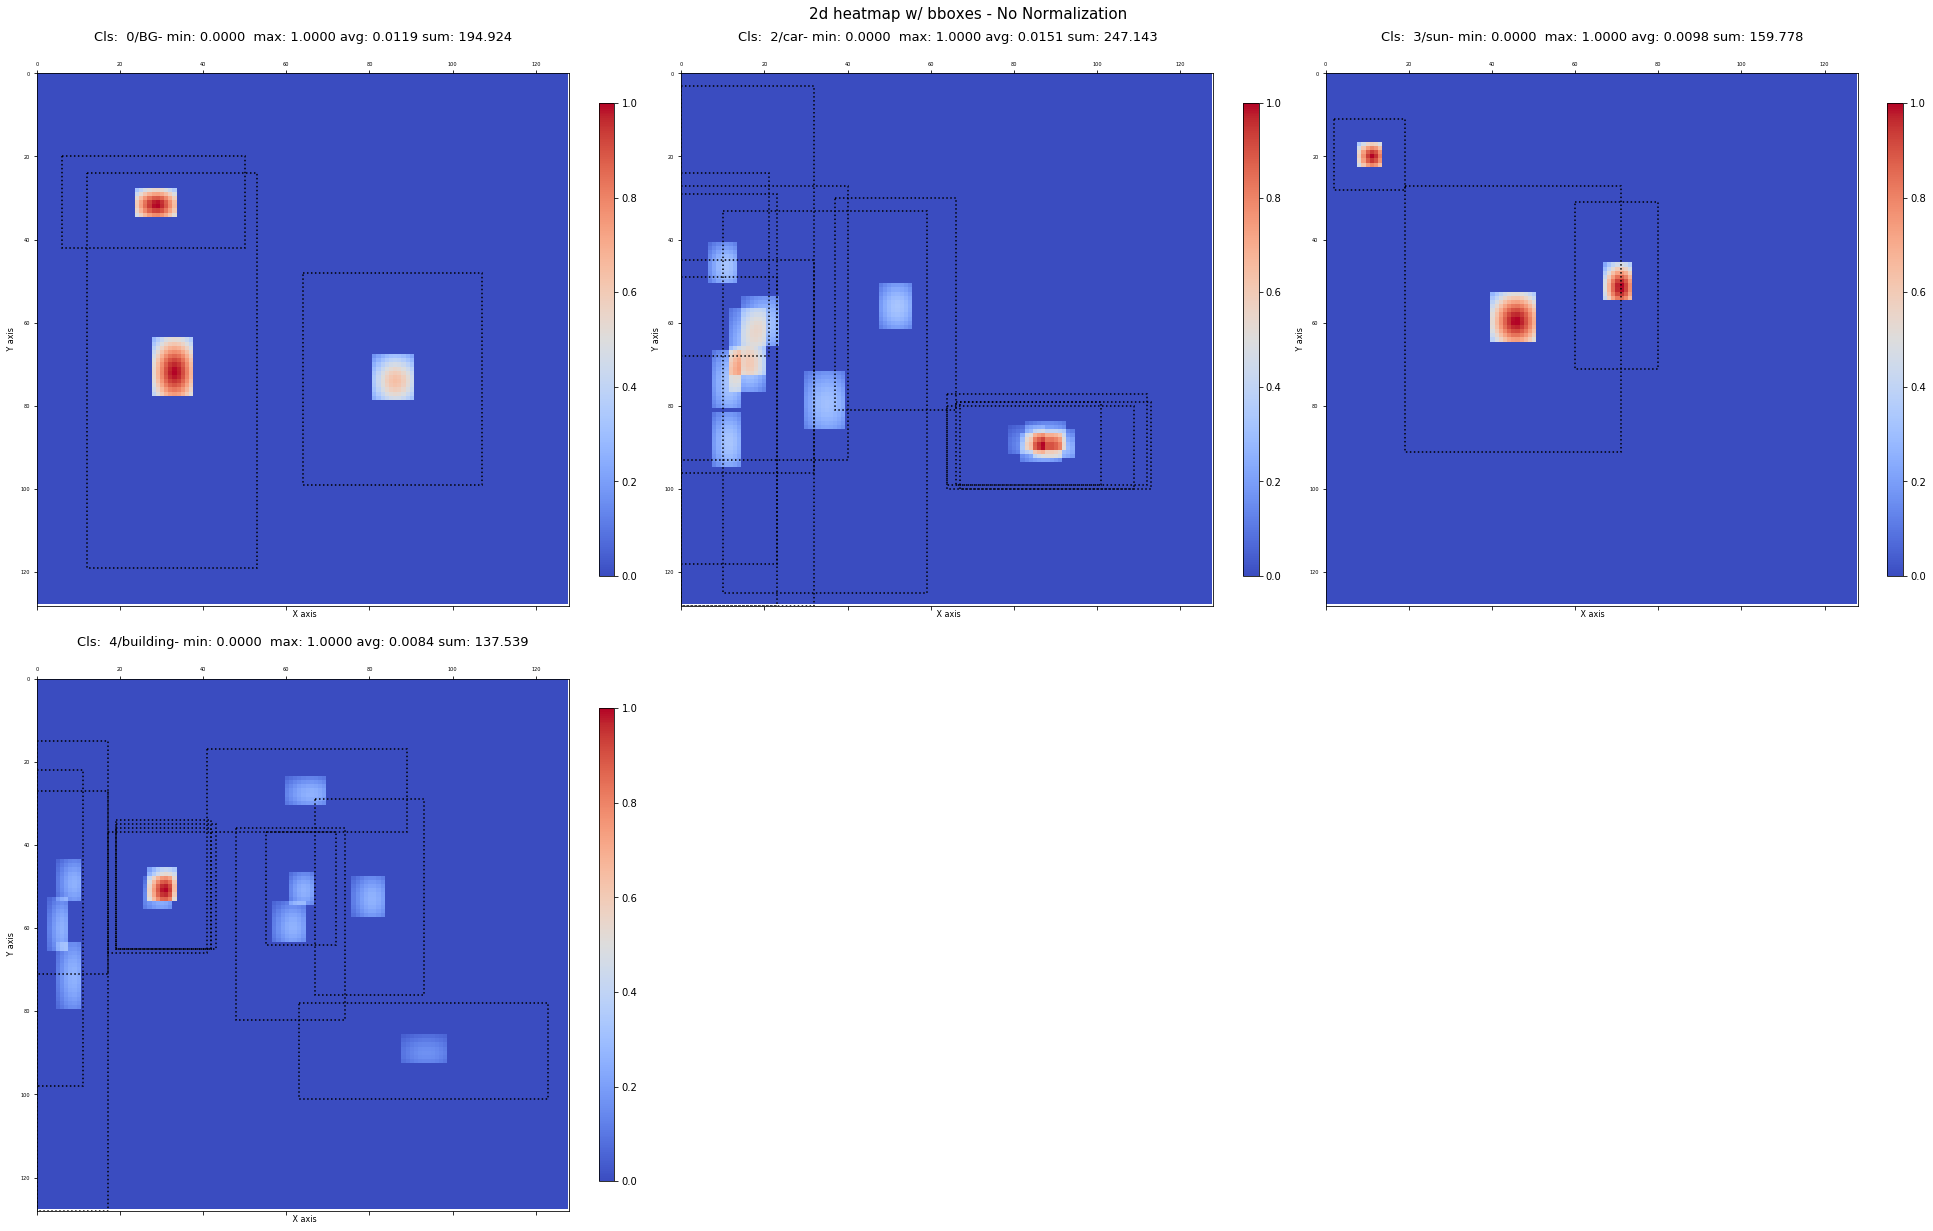

In [85]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    # print(pred_refined_heatmap_scores[img_id,:4])
    print(model_pred_heatmap.shape)
    print(model_pred_heatmap_scores.shape)
    print('Image : {}  ClassIds: {}'.format(img_id, pr_class_ids))
    plot_2d_heatmap(model_pred_heatmap, model_pred_heatmap_scores, img_id, columns = 3, 
                                class_ids = pr_class_ids , 
                                class_names = class_names, scale = 1)   

####  2D plot of `pred_heatmap_norm` returned from model prediction: `res = predict(train_batch_x)`

In [ ]:

for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    # print(pred_refined_heatmap_scores[img_id,:4])
    print(model_pr_heatmap.shape)
    print(model_pr_heatmap_scores.shape)
    print('Image : {}  ClassIds: {}'.format(img_id, pr_class_ids))
    plot_2d_heatmap(r_pr_heatmap, r_pr_heatmap_scores, img_id, columns = 3, 
                                class_ids = pr_class_ids , 
                                class_names = class_names, scale = 4)       
#     plot_2d_heatmap_with_bboxes(res[0], res[1], 
#                                 img_id, class_ids, width=6, height=6, class_names = class_names, scale = 4)

In [ ]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    # print(pred_refined_heatmap_scores[img_id,:4])
    print(r_pr_heatmap_max.shape)
    print(r_pr_heatmap_scores.shape)
    print('Image : {}  ClassIds: {}'.format(img_id, pr_class_ids))
    plot_2d_heatmap(r_pr_heatmap_max, r_pr_heatmap_scores, img_id, columns = 3, 
                                class_ids = pr_class_ids , 
                                class_names = class_names, scale = 4)       
#     plot_2d_heatmap_with_bboxes(res[0], res[1], 
#                                 img_id, class_ids, width=6, height=6, class_names = class_names, scale = 4)

####  2D plot of `model_gt_heatmap_norm` returned from model

(2, 128, 128, 7)
Image : 0  ClassIds: [0, 2, 3, 4]
 Scaling options are 'all', 'class'/'each', 'clip', or 'none' 
 Shape of Z:  (2, 128, 128, 7)  boxes:  (2, 7, 32, 24)
 Image Id:  0  Display classes: [0, 2, 3, 4]
 rows   1  columns : 5 boxes.shape :  (7, 32, 24)
 min_z_all shape: ()  min_z_all: 0.0  max_z_all: () max_z_all: 1.0
 min_z_cls shape: (1, 1, 7)  max_z_cls shape: (1, 1, 7)
 SCALING == none 


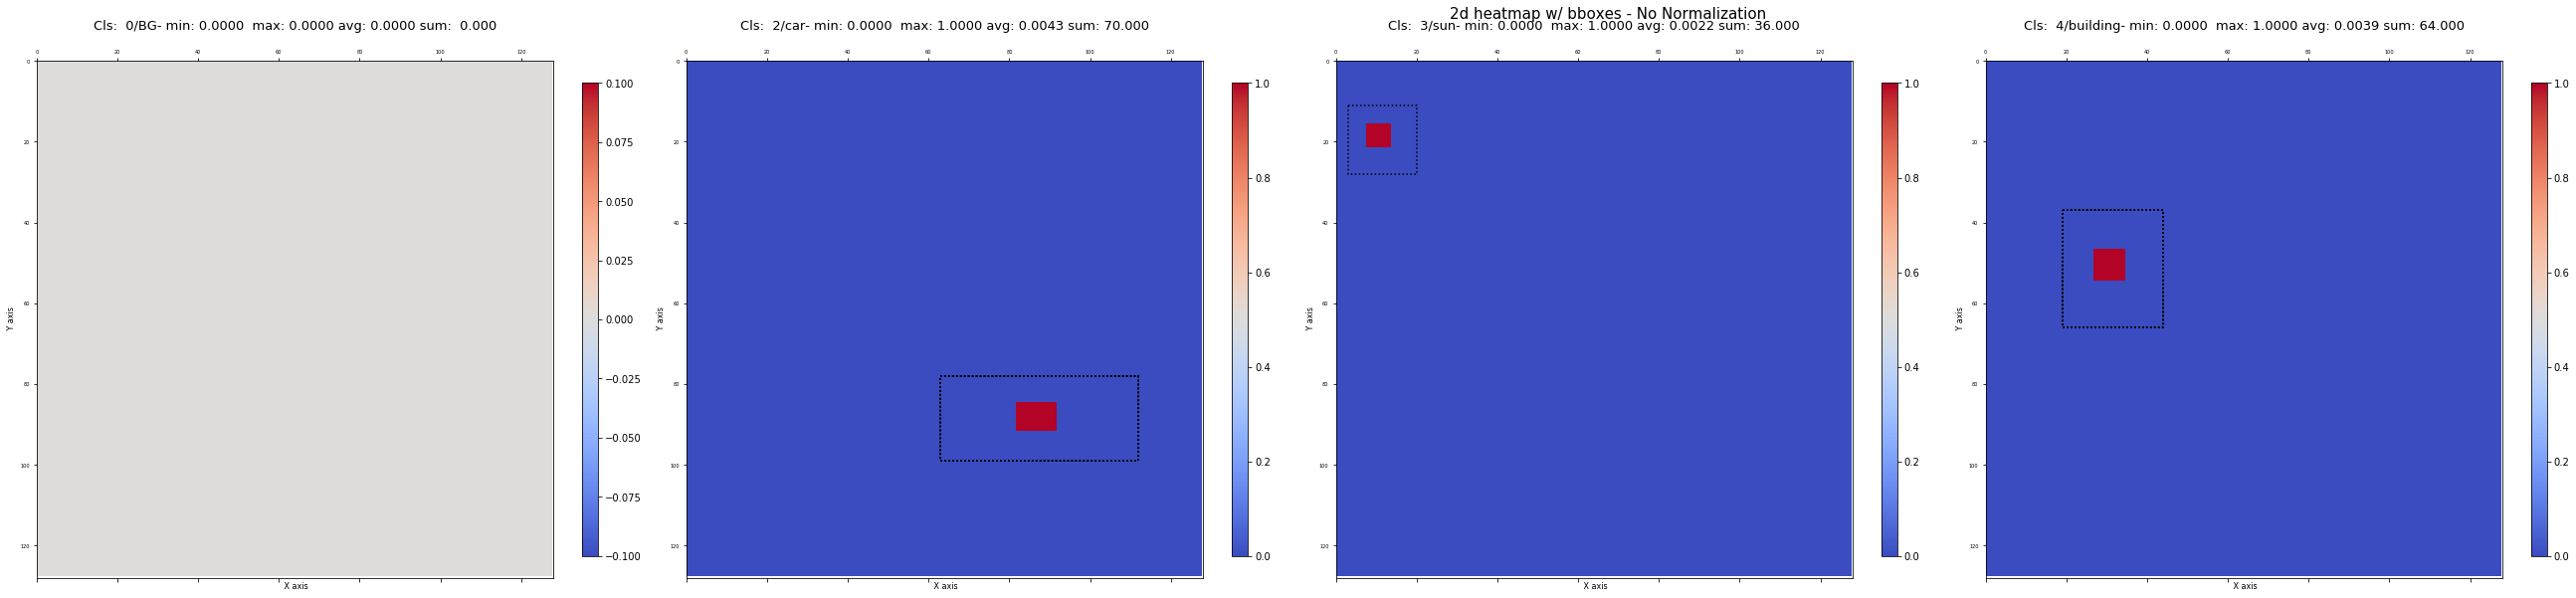

In [88]:
for img_id in [0]:     ##range(mrcnn_config.BATCH_SIZE):
    print(model_gt_heatmap.shape)
    print('Image : {}  ClassIds: {}'.format(img_id, gt_class_ids))
    plot_2d_heatmap_with_bboxes(model_gt_heatmap, model_gt_heatmap_scores, img_id,  
                                class_ids = gt_class_ids, columns= 5, class_names = class_names, scale = 1)

###  3D Plots

####  3D plot of `model_pred_heatmap_norm` returned form model

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    print(model_pred_heatmap_norm.shape)
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(model_pred_heatmap_norm, img_id, class_ids, class_names = class_names)


####  3D plot of  `pred_heatmap_norm` returned form code above

In [ ]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    print(r_pr_heatmap.shape)
#     class_ids = np.unique(pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
#     print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(r_pr_heatmap, img_id, pr_class_ids, class_names = class_names)

In [ ]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    print(r_pr_heatmap_max.shape)
#     class_ids = np.unique(pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
#     print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(r_pr_heatmap_max_norm, img_id, pr_class_ids, class_names = class_names)

####  3D plot of  `model_gt_heatmap_norm` returned form code above

In [ ]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    print(model_gt_heatmap.shape)
    class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(model_gt_heatmap, img_id, class_ids,  class_names = class_names)


####  3D plot of  `gt_heatmap_norm` returned form code above

In [ ]:
for img_id in [1]: ## range(mrcnn_config.BATCH_SIZE):
    print(gt_heatmap_norm.shape)
    class_ids = np.unique(gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(gt_heatmap_norm, img_id, class_ids, width=6, height=6, class_names = class_names)


#### Verfiy max and min of gaussian heatmaps are 1.0 and 0.0, respectively 

In [ ]:
np.set_printoptions(precision=4, threshold=None, linewidth=200, suppress=True)
print(model_pred_heatmap_norm.shape)
hm_max = np.max(model_pred_heatmap_norm, axis = (1,2))
hm_min = np.min(model_pred_heatmap_norm, axis = (1,2))
print(hm_max.shape)
for img_id in range(mrcnn_config.BATCH_SIZE):
    # print(pred_refined_heatmap_scores[img_id,:4])
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('\n Image : {}  ClassIds: {}'.format(img_id, class_ids))
    print('-'*38)
    for cls in class_ids: 
        print(' class: {}   max: {}  min: {}'.format(cls, hm_max[img_id,cls], hm_min[img_id,cls]))
#         print(pred_heatmap_scores[img_id, cls])

print(model_gt_heatmap.shape)
hm_max = np.max(model_gt_heatmap, axis = (1,2))
hm_min = np.min(model_gt_heatmap, axis = (1,2))
print(hm_max.shape)
for img_id in range(mrcnn_config.BATCH_SIZE):
    # print(pred_refined_heatmap_scores[img_id,:4])
    class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('\n Image : {}  ClassIds: {}'.format(img_id, class_ids))
    print('-'*38)
    for cls in class_ids: 
        print(' class: {}   max: {}  min: {}'.format(cls, hm_max[img_id,cls], hm_min[img_id,cls]))
#         print(pred_heatmap_scores[img_id, cls])
        
     

###  Display `pred_scatter` heatmaps for all bounding boxes of an image

In [ ]:
%matplotlib notebook
print('Image id: ',image_id , '    Classes (1: circle, 2: square, 3: triangle ): ')
img = 1
print(pred_heatmap_scores[img,0,0])
plot_bbox_heatmaps(gauss_scatt[img], pred_tensor[img], width = 15, height=25, num_bboxes=12)

###  Display `gauss_heatmap` heatmap (not normalized, normlized, L2 normalized)

In [ ]:

%matplotlib notebook
print('Image id: ',image_id , '    Classes (1: circle, 2: square, 3: triangle ): ')
img = 0
print(pred_heatmap_scores[img,0,0])
# plot_one_heatmap(pred_heatmap[img], pred_heatmap_scores[img], width=19, num_bboxes = 10, title='Non-normalized')
plot_gaussian(pred_heatmap_norm[img,:,:,1],0, 
plot_one_heatmap(pred_heatmap_norm[img], pred_heatmap_scores[img], width=19, num_bboxes = 10, title='normalized')
# plot_one_heatmap(pred_heatmap_L2norm[img], pred_heatmap_scores[img], width=19, num_bboxes = 10, title='L2-normalized')
# plot_heatmaps(pred_heatmap, pred_heatmap_scores, width = 15, num_bboxes=12)

###  Display `gauss_heatmap` 3D heatmap (not normalized, normlized, L2 normalized)

In [ ]:
from mrcnn.visualize import plot_3d_heatmap
%matplotlib notebook
print('Image id: ',image_id , '    Classes (1: circle, 2: square, 3: triangle ): ')
img = 1
print(pred_heatmap_scores[img,cls,:10])

ttl = 'Non-normalized - image: {}'.format(img)
plot_3d_heatmap(pred_heatmap[img], title = ttl, width = 20)
plot_one_heatmap(pred_heatmap[img], pred_heatmap_scores[img], width=15, title=ttl)

ttl = 'Normalized - image: {}'.format(img)
plot_3d_heatmap(pred_heatmap[img], title = ttl, width = 20)
plot_one_heatmap(pred_heatmap[img], pred_heatmap_scores[img], width=15, title=ttl)


###  Find maximum of gaussian distributions for the pred_heatmap
Potentially use this as our heatmap scores 
Found out that using MAX values from the class heatmap (currently generated from the pred_tensor that itself is generated form output_rois and mrcnn_class) is not a viable option, because mutlple max values tend to congreagate around the peak of the gaussian distribution. 
This is also the case for gt_heatmaps.
This will probably also be the case for the FCN output.

#### pred_heatmap

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000)

print(pred_hm.shape)
cls_hm = pred_hm[0,:,:,2]
print(cls_hm.shape)
print(np.unravel_index(np.argmax(cls_hm) , cls_hm.shape) )
print(np.max(cls_hm))

print(pred_hm_norm.shape)
cls_hm_norm = pred_hm_norm[0,:,:,2]
print(cls_hm_norm.shape)
print(np.unravel_index(np.argmax(cls_hm_norm) , cls_hm_norm.shape) )
print(np.max(cls_hm_norm))


In [ ]:
hm_ls =np.ravel(cls_hm)
hm_ls_norm = np.ravel(cls_hm_norm)
srtlst = np.argsort(hm_ls)
srtlst_norm = np.argsort(hm_ls_norm)
print(' Sortlist')
print(srtlst[::-1])
print(srtlst.shape)
print('---- norm ------')
print(srtlst_norm[::-1])
print(srtlst_norm.shape)

print(' Top scores')
top_scores = srtlst[:-21:-1]
print('---- norm ------')
top_scores_norm = srtlst_norm[:-21:-1]
print(len(top_scores),top_scores)
print(' Top items ')
for i in top_scores :
    print( i , '  ', np.unravel_index(i, cls_hm.shape))
print('---- norm ------')    
for i in top_scores_norm :
    print( i , '  ', np.unravel_index(i, cls_hm_norm.shape))
print(' Top scores ')
print(hm_ls[top_scores])
print('---- norm ------')    
print(hm_ls_norm[top_scores_norm])


#### gt_heatmap

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000)
print(pred_hm.shape)
cls_hm = gt_hm[0,:,:,2]
print(cls_hm.shape)
print(np.unravel_index(np.argmax(cls_hm) , cls_hm.shape) )
print(np.max(cls_hm))

print('---- norm -----')
print(gt_hm_norm.shape)
cls_hm_norm = gt_hm_norm[0,:,:,2]
print(cls_hm_norm.shape)
print(np.unravel_index(np.argmax(cls_hm_norm) , cls_hm_norm.shape) )
print(np.max(cls_hm_norm))



In [ ]:
hm_ls =np.ravel(cls_hm)
hm_ls_norm = np.ravel(cls_hm_norm)
srtlst = np.argsort(hm_ls)
srtlst_norm = np.argsort(hm_ls_norm)
print(' Sortlist')
print(srtlst[::-1])
print(srtlst.shape)
print('---- norm ------')
print(srtlst_norm[::-1])
print(srtlst_norm.shape)

print(' Top scores')
top_scores = srtlst[:-21:-1]
print('---- norm ------')
top_scores_norm = srtlst_norm[:-21:-1]
print(len(top_scores),top_scores)
print(' Top items ')
for i in top_scores :
    print( i , '  ', np.unravel_index(i, cls_hm.shape))
print('---- norm ------')    
for i in top_scores_norm :
    print( i , '  ', np.unravel_index(i, cls_hm_norm.shape))
print(' Top scores ')
print(hm_ls[top_scores])
print('---- norm ------')    
print(hm_ls_norm[top_scores_norm])


In [ ]:
max_a = np.max(cls_pred_heatmap)
print(max_a.shape)

print(np.unravel_index(np.argmax(prob_a) , prob_a.shape) )

print()

print(' covar ', covar_sqrd)
print(prob_b[35:50, 45:54])
max_b = np.max(prob_b)
print(np.unravel_index(np.argmax(prob_b) , prob_b.shape) )

print('max a , max_b ', max_a, max_b, max_a/max_b)

##  `development build_heatmap_tf ()` 

### Generate Multivariate Normal Distribution from Pred_Tensor

`pred_tensor[:,:,:,1:7]`  == `[116.9736  21.8213  36.2715  45.6026   0.    0.9139   ]`


Detections returned by `detect()` routine:

`[[ 25.          18.          80.          72.           2.           0.99936014]
  [ 51.           3.         106.          71.           3.           0.99924326]`

### Prepare values to pass to build_gaussian_tf

In [ ]:
img = 1
max_score = np.max(mrcnn_class, axis = -1)
max_class = np.argmax(mrcnn_class, axis = -1)
print(' output_rois[',img,'] \n', output_rois[1]*[128,128,128,128])
print('max class shape:',max_class.shape, 'max score shape: ',max_score.shape)
print('max class[',img,']\n',max_class[img])
print('max score[',img,']\n',max_score[img])
print(' mrcnn class.shape ',mrcnn_class.shape)
print('marcnn_classe[',img,',:]\n',mrcnn_class[1,:])
# print(output_rois[1])
 

####  Display for visual check - `pred_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_tensor shape is ', pred_tensor.shape)
img = 0
print('Image ', img , '/ Class 0 ------------')
print(pred_tensor[img,0])
print('Image ', img , '/ Class 1 ------------')
print(pred_tensor[img,1])
print('Image ', img , '/ Class 2 ------------')
print(pred_tensor[img,2])
print('Image ', img , '/ Class 3 ------------')
print(pred_tensor[img,3])


####  Display for visual check - `gt_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_tensor shape is ', gt_tensor.shape)
img = 1
print('Image ', img , '/ Class 0 ------------')
print(gt_tensor[img,0])
print('Image ', img , '/ Class 1 ------------')
print(gt_tensor[img,1])
print('Image ', img , '/ Class 2 ------------')
print(gt_tensor[img,2])
print('Image ', img , '/ Class 3 ------------')
print(gt_tensor[img,3])




### Plot heatmap produced by network `fcn_bilinear` and compare with `pred_gaussian`

In [ ]:
from mrcnn.visualize import plot_gaussian, plot_gaussian_2d
import matplotlib as plt

%matplotlib notebook
img = 2
cls = 2
image_id = input_image_meta[img,0]
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
Zout1 = pred_heatmap     # gt_gaussiam 
Zout2 = pred_heatmap_norm  # fcn_bilinear
Zout3 = pred_heatmap_L2norm  # fcn_bilinear

print(Zout1.shape, Zout2.shape)
num_images = config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES
print(pred_tensor[img,cls,:10])
print(pred_tensor.shape)
print('Image id: ',image_id)
print('Classes (1: circle, 2: square, 3: triangle ): ')

width = 9
# for j in [cls] : #range(num_classes):
print(pred_heatmap_scores[img,cls,:10])
ttl = 'Pred_hm      - image :  {} class: {} '.format(img,j)
plot_gaussian_2d(Zout1[img,:,:,j], title = ttl, width = width)

ttl = 'pred_norm - image :  {} class: {} '.format(img,j)     
plot_gaussian_2d(Zout2[img,:,:,j], title = ttl, width = width)  

ttl = 'pred_norm_L2 - image :  {} class: {} '.format(img,j)     
plot_gaussian_2d(Zout3[img,:,:,j], title = ttl, width = width)  


from mrcnn.visualize import display_gt_bboxes, display_roi_proposals
model_info = [model, config, dataset_train, train_generator]
display_roi_proposals(model_info, input_image_meta, pred_tensor, [cls], 0)

In [ ]:
%matplotlib notebook
width = 12
plot_gaussian2([pred_heatmap_norm, fcn_heatmap_norm], image_idx = 0, title = ttl, width = width)  


###  Test `means`, `covar`, `gauss_grid`, and `gauss_sum ` between development version and final version

In [ ]:
print(means.get_shape(), means.get_shape())
tst1 = means.eval()
tst2 = means2.eval()
print(tst1.shape, tst2.shape)

print(tst1[0,:10])
print()
print(tst2[0,:10])
print(np.all(tst1 == tst2))
print()
del tst1, tst2

In [ ]:
tst1 = st.eval()
tst2 = st2.eval()
print(tst1.shape, tst2.shape)

print(tst1[0,:10])
print()
print(tst2[0,:10])
print(np.all(tst1 == tst2))
print()
del tst1, tst2

In [ ]:
tst1 = gauss_grid.eval()
tst2 = gauss_grid2.eval()
print(tst1.shape, tst2.shape)

print(tst1[0,0,:10])
print()
print(tst2[0,0,:10])
print(np.all(tst1 == tst2))
# print()
del tst1, tst2

In [ ]:
tst1 = gauss_sum.eval()
tst2 = gauss_sum2.eval()
print(tst1.shape, tst2.shape)

# print(tst1[0,0,:10])
# print()
# print(tst2[0,0,:10])
print(np.all(tst1 == tst2))
# print()
del tst1, tst2

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000)
from scipy.stats import  multivariate_normal
# Build mesh-grid to hold pixel coordinates ----------------------------------
XX = np.arange(0, img_w, 1)
YY = np.arange(0, img_h, 1)
XX, YY = np.meshgrid(XX, YY)
print('XX shape', XX.shape)
pos  = np.empty(XX.shape + (2,))   # concatinate shape of x to make ( x.rows, x.cols, 2)
pos[:,:,0] = XX;
pos[:,:,1] = YY;
print('XX')
print(XX)
print('YY')
print(YY)
print(pos[0,:,:])
print(pos[0])
print(grid[0].eval())
print(' pos type    ', type(pos), type(grid))
print(' grid shape ', pos.shape, grid.shape)
print(np.all(pos == grid.eval()))
mean = np.array([1,2])
covar = np.array([[1,0],[0,1]])
print(' mean  ', mean)
print(' covar ', covar)
mvna   = multivariate_normal(mean, covar)
prob_a = mvna.pdf(pos)

# mvnb = multivariate_normal(mean, covar_sqrd)
# prob_b = mvnb.pdf(pos)

# print(prob_a[35:50, 45:54])
# max_a = np.max(prob_a)
# print(np.unravel_index(np.argmax(prob_a) , prob_a.shape) )

# print()

# print(' covar ', covar_sqrd)
# print(prob_b[35:50, 45:54])
# max_b = np.max(prob_b)
# print(np.unravel_index(np.argmax(prob_b) , prob_b.shape) )

# print('max a , max_b ', max_a, max_b, max_a/max_b)

In [ ]:
with sess.as_default():
    #-----------------------------------------------------------------------------
    ## Build mesh-grid to hold pixel coordinates  
    #-----------------------------------------------------------------------------
    X = tf.range(80, dtype=tf.int32)
    Y = tf.range(80, dtype=tf.int32)
    X, Y = tf.meshgrid(X, Y)

    # duplicate (repeat) X and Y into a  batch_size x rois_per_image tensor
    print('    X/Y shapes :',  X.get_shape(), Y.get_shape())
    ones = tf.ones([1, 1, 1], dtype = tf.int32)
    rep_X = ones * X
    rep_Y = ones * Y 
    print('    Ones:    ', ones.shape)                
    print('    ones_exp * X', ones.shape, '*', X.shape, '= ',rep_X.shape)
    print('    ones_exp * Y', ones.shape, '*', Y.shape, '= ',rep_Y.shape)

    # # stack the X and Y grids 
    bef_pos = tf.to_float(tf.stack([rep_X,rep_Y], axis = -1))
    print('    before transpse ', tf.shape(bef_pos).eval())
    pos_grid = tf.transpose(bef_pos,[1,2,0,3])
    print('    after transpose ', tf.shape(pos_grid).eval())    
    pt2_den = tf.constant([[10,10,30,70]], dtype = tf.float32)
    print(type(pt2_den))
    #-----------------------------------------------------------------------------
    ##  Build mean and convariance tensors for Multivariate Normal Distribution 
    #-----------------------------------------------------------------------------
    width  = pt2_den[:,3] - pt2_den[:,1]      # x2 - x1
    height = pt2_den[:,2] - pt2_den[:,0]
    print(width.eval(), type(width))
    print(height.eval(), type(height))
    cx     = pt2_den[:,1] + tf.div( width  , 2.0)
    cy     = pt2_den[:,0] + ( height / 2.0)
    means  = tf.stack((cx,cy),axis = -1)
    covar  = tf.stack((width * 0.5 , height * 0.5), axis = -1)
    covar  = tf.sqrt(covar)
    print(means.eval())
    print(covar.eval())

    tfd = tf.contrib.distributions
    mvn = tfd.MultivariateNormalDiag( loc  = means,  scale_diag = covar)
    prob_grid = mvn.prob(pos_grid)
    print('     Prob_grid shape before tanspose: ',prob_grid.get_shape())
    prob_grid = tf.transpose(prob_grid,[2,0,1])
    print('     Prob_grid shape after tanspose: ',prob_grid.get_shape())    
    print('    >> input to MVN.PROB: pos_grid (meshgrid) shape: ', pos_grid.get_shape())
    print('    << output probabilities shape:' , prob_grid.get_shape())


## Plot Image with bounding boxes from `output_rois`

In [ ]:
img_idx = 0
image_id = input_image_meta[img_idx,0]
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
bbox = utils.extract_bboxes(mask)

log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)

# class_names = [str(dataset_train.class_names[class_id]) for class_id in class_ids]
class_names = dataset_train.class_names
# visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
print('Classes     : ', class_ids)
print("image_id    : ", image_id, ' Reference: ', dataset_train.image_reference(image_id))
print(' class_ids    : ', class_ids.shape[0])
print(' bbox         : ', bbox.shape[0])
print(' output_rois: : ', output_rois.shape)
print(' Image id     : ', image_id , '  Image meta', img_meta[img_idx,:10])
print(' Classes      : ', [class_names[i] for i in class_ids])
print(' Image window : ', img_meta[0, 4:8])
print(' Image shape  : ', image.shape)


#### Display `output_roi` without  delta refinement

In [ ]:
unormalized_rois = output_rois[img_idx] * [1024,1024,1024,1024]
unrefined_rois   = utils.boxes_to_image_domain(unormalized_rois, img_meta[0] )
visualize.draw_rois(image, unrefined_rois, target_class_ids[0], class_names, limit=5) #, random = True)

#### Display `output_rois` with after clipping to image boundaries

In [ ]:
clipped_rois = utils.clip_to_window_np(img_meta[0, 4:8], unormalized_rois)
clipped_rois = utils.boxes_to_image_domain(clipped_rois, img_meta[0] )
visualize.draw_rois(image, clipped_rois , target_class_ids[0], class_names, bbox_ids = [0,1,2]) # or , limit=2)

####  Displayt `output_rois` after applying `target_bbox_deltas`

NOTE: MUST BE MULTIPLIED BY BBOX_STD_DEV

In [ ]:
print(' Target_bbox_deltas: ',target_bbox_deltas.shape)
## 1- Apply Bounding Box Standard Deviation and apply to output_rois
apply_deltas = target_bbox_deltas[img_idx] * mrcnn_config.BBOX_STD_DEV
refined_rois = utils.apply_box_deltas_np(output_rois[img_idx], apply_deltas)
print(' Refined ROIs shape: ',refined_rois.shape)
# print(refined_rois[:20])

## 3- Clip to image windoow boundaries:
refined_rois = refined_rois * [1024,1024,1024,1024]
refined_rois = utils.clip_to_window_np(img_meta[0, 4:8], refined_rois)

## 4- Transfer to image coordniates :
refined_rois = utils.boxes_to_image_domain(refined_rois, img_meta[0] )
## 5- Visualize
visualize.draw_rois(image, refined_rois, target_class_ids[0], class_names,bbox_ids = [0,1,2], limit=5)

#### Apply predicted `mrcnn_bbox` delta refinements to `output_rois` and display

In [ ]:
# Create un
unormalized_rois = output_rois[img_idx] * [1024,1024,1024,1024]
clipped_rois = utils.clip_to_window_np(img_meta[0, 4:8], unormalized_rois)
unrefined_rois   = utils.boxes_to_image_domain(clipped_rois, img_meta[0] )

## 1- Extract predicted deltas from mrcnn_bbox
classes, deltas = get_predicted_mrcnn_deltas(mrcnn_class, mrcnn_bbox, verbose = False)
# print(classes.shape, deltas.shape)
# print(classes[0,:20])
# print(deltas[0,:20])


## 2- Apply Bounding Box Standard Deviation and apply to output_rois
apply_deltas = deltas[0] * mrcnn_config.BBOX_STD_DEV
refined_rois = utils.apply_box_deltas_np(output_rois[img_idx], apply_deltas)
print(' Refined ROIs shape: ',refined_rois.shape)
# print(refined_rois[:20])

## 3- Clip to image windoow boundaries:
refined_rois = refined_rois * [1024,1024,1024,1024]
refined_rois = utils.clip_to_window_np(img_meta[0, 4:8], refined_rois)

## 4- Transfer to image coordniates :
refined_rois = utils.boxes_to_image_domain(refined_rois, img_meta[0] )

# Visualize
visualize.draw_rois(image, unrefined_rois, target_class_ids[0], class_names,  limit=5)
visualize.draw_rois(image, refined_rois, target_class_ids[0], class_names,  limit=5)
# visualize.draw_rois_with_refinements(image, unrefined_rois, refined_rois, target_class_ids[0], class_names, limit=10)

#### Display `image_gt_bboxes` provided by data generator

In [ ]:
# Display image and instances
# visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names)   

# print(input_gt_bboxes[0,:20])
gt_bboxes = utils.boxes_to_image_domain(input_gt_bboxes[0], img_meta[0] )
visualize.draw_rois(image, gt_bboxes[:20], input_gt_class_ids[0,:20], class_names, limit=10)

## misc code

#### sparse to dense

In [ ]:
with sess.as_default():
    tf_dense = tf.sparse_to_dense(pt2_ind), in_tensor.shape[:-1], 1,0)
    r_tf_dense = tf_dense.eval()
print(r_tf_dense.shape)    
print(r_tf_dense[0])


####  Display for visual check - `pred_heatmap_norm` is the final result from  `build_heatmap()`

In [ ]:
print(pred_heatmap_norm.shape)
temp = pred_heatmap_norm
np.set_printoptions(linewidth=150, threshold=10000, suppress=False)
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
        print('img ',i,' class ', j, ' sum:',temp_sum[i,j],  ' max: ',np.max(temp[i,:,:,j]),' mean: ', np.mean(temp[i,:,:,j]),' min: ', np.min(temp[i,:,:,j]))    

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6, suppress=True)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_heatmap_scores shape is ', pred_heatmap_scores.shape)
for img in [0,1,2]:
    for k in range(4):
        print('Image ', img , '/ Class ',k,' ------------')
        print(np.min(pred_heatmap_scores[img,k,:,8]))
        print(pred_heatmap_scores[img,k])

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
print('gt_heatmap_scores shape is ', gt_heatmap_scores.shape)
img = 1
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(gt_heatmap_scores[img,k])

In [ ]:
sess = KB.get_session()
with sess.as_default():
    temp = fcn_heatmap
    np.set_printoptions(linewidth=150, threshold=10000)
    print('  output shapes :',  temp.get_shape())
    temp_sum = tf.reduce_sum(temp, [2,3])
    temp_min = tf.reduce_min(temp, [2,3])
    temp_max = tf.reduce_max(temp, [2,3])
    temp_avg = tf.reduce_mean(temp, [2,3])
    print('temp_sum is ', temp_sum.shape)
    for i in range(5):
        for j in range(4):
                print('img/cls ',i,'/', j,'  sum:',temp_sum[i,j], 'min',temp_min[i,j] ,'max',temp_max[i,j] ,'avg',temp_avg[i,j])

#### `byclas_to_byimage()` reshape tensor / numpy array from per_class to per image 

In [ ]:
def byclass_to_byimage_np(in_array, seqid_column):    
    ''' 
    convert a by class tensor shaped  [batch_size, num_classes, num_bboxes, columns ] to 
            a by image tensor shaped  [batch_size, num_bboxes, columns]
    '''
    #     np_sum = np.sum(np.abs(model_gt_heatmap_scores[:,:,:,0:4]), axis=-1)
    #     print(np_sum.shape)
    #     a,b,c = np.where(np_sum > 0)
    a,b,c = np.where(in_array[...,seqid_column]>0)

    output = np.zeros((in_array.shape[0],in_array.shape[-2],in_array.shape[-1]))
#     print(' output shape is ',output.shape)
#     print(a.shape, b.shape,c.shape)
    
    for img, cls , box in zip(a, b,c):
#         print( img,cls, box, 200 - in_array[img, cls, box,6].astype(int))
        output[img, 200 - in_array[img, cls, box,6].astype(int)] = in_array[img, cls, box]

    return output

def byclass_to_byimage_tf(in_array, seqid_column):    
    ''' 
    convert a by class tensor shaped  [batch_size, num_classes, num_bboxes, columns ] to 
            a by image tensor shaped  [batch_size, num_bboxes, columns]
    '''
    aa = tf.reshape(in_array, [in_array.shape[0], -1, in_array.shape[-1]])
    _ , sort_inds = tf.nn.top_k(tf.abs(aa[:,:,seqid_column]), k= in_array.shape[2])
    batch_grid, bbox_grid = tf.meshgrid(tf.range(in_array.shape[0]), tf.range(in_array.shape[2]),indexing='ij')
    gather_inds = tf.stack([batch_grid, sort_inds],axis = -1)
    output = tf.gather_nd(aa, gather_inds )
    return output

####  Try `byclass_to_byimage()` on `gt_heatmap_scores`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print(gt_heatmap_scores.shape)
# outp = byclass_to_byimage_tf(gt_heatmap_scores,6)
# with sess.as_default():
#      r_outp = outp.eval()
# print(r_outp.shape)
# print(r_outp[0])
# print(r_outp[1])


# print(tf_model_pred_heatmap_scores.shape, tf_model_pred_heatmap_scores)
# outp = byclass_to_byimage_tf(tf_model_pred_heatmap_scores,6)
# with sess.as_default():
#      r_outp = outp.eval()
# print(r_outp.shape)
# print(r_outp[0])
# print(r_outp[1])

####  Try `byclass_to_byimage()` on `pred_heatmap_scores`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)

tf_model_pred_heatmap_scores = tf.constant(model_pred_heatmap_scores) 

print('pred_heatmap_scores shape is       ', pred_heatmap_scores.shape )
print('pred_heatmap_scores from model is :', tf_model_pred_heatmap_scores.shape,tf_model_pred_heatmap_scores)
r_out2 = byclass_to_byimage_np(pred_heatmap_scores,6)

with sess.as_default():
    r_out1 = byclass_to_byimage_tf(tf_model_pred_heatmap_scores,6).eval()

for img in range(2):
    class_ids = np.unique(pred_heatmap_scores[img,:,:,4]).astype(int).tolist()    
    print('Classids: ', class_ids)
    print('Image ', img ,' ------------')
    for j in range(200):
        print('tf: ',r_out1[img,j])
        print('np: ',r_out2[img,j])
        print()

#### ground work for writing `byclass_to_by_image()`

In [ ]:
# print(pred_heatmap_scores.shape)
# gt_heatmap_scores = tf.identity(model_gt_heatmap_scores)
# aa = tf.reshape(gt_heatmap_scores, [gt_heatmap_scores.shape[0], -1, gt_heatmap_scores.shape[-1]])
# _ , sort_inds = tf.nn.top_k(tf.abs(aa[:,:,6]), k=gt_heatmap_scores.shape[2])
# print(sort_inds.shape)
# batch_grid, bbox_grid = tf.meshgrid(tf.range(batch_size), tf.range(gt_heatmap_scores.shape[2]),indexing='ij')
# gather_inds = tf.stack([batch_grid, sort_inds],axis = -1)
# print(aa.shape)
# print(bb.shape)
# cc = tf.gather_nd(aa, gather_inds )
# print('cc : ',cc.shape)
# with sess.as_default():
# #     r_pred_heatmap_scores = gauss_scores.eval()
#     r_aa = aa.eval()
#     r_sort_inds = sort_inds.eval()
#     r_gather_inds = gather_inds.eval()
# #     r_bb = bb.eval()
#     r_cc = cc.eval()
# #     r_dd = dd.eval()
# # print(r_pred_heatmap_scores[0,1])
# print('cc: ',r_cc.shape)
# print('bb: ',r_bb.shape)
# print('aa: ',r_aa.shape)
# # print(r_sort_inds)
# print(r_gather_inds)
# # print(r_bb)
# print(r_cc[0])
print(r_cc[1])

####  Convert `pred_heatmap_scores` using `byclass_to_byimage_np`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print(model_pred_heatmap_scores.shape)
print(model_pred_heatmap_scores[0,0,0])
outp = byclass_to_byimage_np(model_pred_heatmap_scores,6)
print(outp[0])

####  Convert `gt_heatmap_scores` using `byclass_to_byimage_np`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)

# print('pred_heatmap_scores shape is       ', gt_heatmap_scores.shape )
print('pred_heatmap_scores from model is :', model_gt_heatmap_scores.shape)
print(model_gt_heatmap_scores[0,1])

# with sess.as_default():
#     r_pred_tensor = pred_tensor.eval()
# for img in range(2):
#     class_ids = np.unique(model_gt_heatmap_scores[img,:,:,4]).astype(int).tolist()    
#     print('Classids: ', class_ids)
#     for i in class_ids:
#         print('Image ', img , '/ Class ',i,' ------------')
#         for j in range(200):
#             print(gt_heatmap_scores[img,i,j])
#             print(model_gt_heatmap_scores[img,i,j])
# #         print(pred_refined_tensor[img,i,j])
#         print()
 
outp = byclass_to_byimage_np(model_gt_heatmap_scores,6)
print(outp[0])

####  Display for visual check - `pred_heatmap_scores`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_heatmap_scores shape is ', pred_heatmap_scores.shape)
img = 0
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(pred_heatmap_scores[img,k])

####  Display for visual check - `pred_heatmap_norm`  

In [ ]:
print(pred_heatmap_norm.shape)
temp = pred_heatmap_norm
np.set_printoptions(linewidth=150, threshold=10000)
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
            print('img ',i,' class ', j, ' sum:',temp_sum[i,j])

####  Run TF graph

In [ ]:
# with sess1.as_default():
# FeedList = [positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_class_ids, roi_gt_boxes, roi_gt_box_assignment ]
# FeedList = [ rois, roi_gt_class_ids,  roi_gt_deltas, roi_gt_boxes]
Fetches  = [ pred_heatmap, pred_heatmap_norm, pred_heatmap_scores]
tt = sess.run(Fetches)
print(type(tt), len(tt))
for i in tt:
    print(type(i), i.shape)